# Lib

In [1]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import torch 
import numpy as np 
import glob 
import os 
import io 
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import matplotlib
import pandas as pd 
# plt.style.use('seaborn-v0_8-darkgrid'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def check_data(data):
    for k,v in data.items():
        if isinstance(v,np.ndarray):
            print(k,v.shape)
        else:
            try:
                print(k, 'Length: ', len(v))
            except:
                print(k, v)

def load_data(path):
    data = np.load(path,allow_pickle=True).item()
    return data 

# Func


In [3]:
def parse_dir(path,include=[]):
    n_include = len(include)
    list_data_path = [ None for _ in range(n_include)]
    for p in glob.glob(path+'/*.npy'):
        tmp_p = p.split('/')[-1]
        tmp_p = tmp_p.split('-')
        for i,inc in enumerate(include):
            if inc in tmp_p:
                list_data_path[i] = p  
    # return sorted(list_data_path)
    return list_data_path 

In [4]:
def get_eval_data(path):
    data = load_data(path)
    res = {}
    # name = data['name']
    n_agent = len(data['first_done']) 
    # res['eval_name'] = name

    list_stability, list_tracking_error, list_path_length = [], [], []
    list_fall_rate = []
    # check_data(data)
    for i in range(n_agent):
        first_done = data['first_done'][i]
        tracking_error = data['tracking_error'][i]
        list_path_length.append(first_done)
        list_fall_rate.append(data['Fall'][i])

        # vel_roll = data['base_vel_roll'][i][0: first_done]
        # vel_pitch = data['base_vel_pitch'][i][0: first_done]
        vel_roll = data['base_vel_roll'][i]
        vel_pitch = data['base_vel_pitch'][i]
        stability = np.sqrt(np.square(vel_roll) + np.square(vel_pitch))
        list_stability.append(np.mean(stability))
        list_tracking_error.append(np.mean(tracking_error))
        # list_tracking_error.append(np.mean(tracking_error[0: first_done]))

    list_stability = np.array(list_stability)
    list_tracking_error = np.array(list_tracking_error)
    list_path_length = np.array(list_path_length)
    list_fall_rate = np.array(list_fall_rate)
    res['stability'] = list_stability
    res['tracking_error'] = list_tracking_error
    res['path_length'] = list_path_length
    res['fall_rate'] = list_fall_rate
    return res  
    
def get_df(list_data:list):
    list_df = []
    for data in list_data:
        df = pd.DataFrame(data)
        df['name'] = data['eval_name']
        list_df.append(df) 
    df = pd.concat(list_df) 
    return df

# 分布内泛化测试

In [7]:
def prepare_single_force_data(list_data_path:list , list_data_name: list, force_val = 50):
    list_df = []
    for i,data_path in enumerate(list_data_path):
        data = get_eval_data(data_path)
        df = pd.DataFrame(data)
        df['name'] = list_data_name[i]
        df['force'] = force_val
        print("check data: ", list_data_name[i], data_path.split('/')[-1])
        list_df.append(df)
    df = pd.concat(list_df)
    return df 

def plot_iid_test(df, y_name, x_name, hue_name, save_path, y_label, x_label, title, ylim=None, xlim=None, 
                  remove_outliers = False,
                  plot_type = 'box',
                  title_fontsize=22, label_fontsize=22, legend_fontsize=16, legend_location='upper left', save_name = 'Eval'):
    if remove_outliers:
        Q1 = df[y_name].quantile(0.25)
        Q3 = df[y_name].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[y_name] < (Q1 - 1.5 * IQR)) |(df[y_name] > (Q3 + 1.5 * IQR)))]

    fig, ax = plt.subplots(figsize=(12,8))
    sns.set_style("darkgrid")
    if plot_type == 'box':
        box = sns.boxplot(data=df, x=x_name, y=y_name, hue=hue_name, ax=ax)
    elif plot_type == 'bar':
        box = sns.barplot(data=df, x=x_name, y=y_name, hue=hue_name, ax=ax)
    
    ax.set_ylabel(y_label, fontsize=label_fontsize)
    ax.set_xlabel(x_label, fontsize=label_fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    ax.tick_params(axis='both', labelsize=legend_fontsize)
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    
    # plt.legend(bbox_to_anchor=(1.15, 0.8), loc=legend_location, borderaxespad=0., fontsize=legend_fontsize)
    plt.legend(loc=legend_location, borderaxespad=0., fontsize=legend_fontsize)
    
    plt.tight_layout()
    if save_path is not None:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_path = os.path.join(save_path, save_name+'.pdf')
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

## Ablation 


In [25]:
list_data_name = ['PPO','RMA','E-Net','Our Method']
force_values = [10,15,20,25,30,35,40,45,50,55,60,65,70]
include = ['VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']
list_data_name = ['1_head', '2_head', '4_head', '8_head', '16_head', '32_head']

# include = ['Expert', 'RMA', 'VQ_1_head',  'VQ_4_head', ]
# list_data_name = ['PPO', 'RMA', 'E-Net', 'Our Method']

dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval2/iid/v05/{force}N",include=include)
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)
print(df.describe())

result = df.groupby('name').agg({'stability': ['mean', 'std'],
                                 'tracking_error': ['mean', 'std'],
                                 'fall_rate': ['mean', 'std']})

result = result.round(2)

result.to_csv('data/eval2/ablation/iidv05.csv')

check data:  1_head VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v05-force-10N.npy
check data:  2_head VQ-VQ_2_head-stationary_push-VQ_2_head-iid_v05-force-10N.npy
check data:  4_head VQ-VQ_4_head-stationary_push-VQ_4_head-iid_v05-force-10N.npy
check data:  8_head VQ-VQ_8_head-stationary_push-VQ_8_head-iid_v05-force-10N.npy
check data:  16_head VQ-VQ_16_head-stationary_push-VQ_16_head-iid_v05-force-10N.npy
check data:  32_head VQ-VQ_32_head-stationary_push-VQ_32_head-iid_v05-force-10N.npy
check data:  1_head VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v05-force-15N.npy
check data:  2_head VQ-VQ_2_head-stationary_push-VQ_2_head-iid_v05-force-15N.npy
check data:  4_head VQ-VQ_4_head-stationary_push-VQ_4_head-iid_v05-force-15N.npy
check data:  8_head VQ-VQ_8_head-stationary_push-VQ_8_head-iid_v05-force-15N.npy
check data:  16_head VQ-VQ_16_head-stationary_push-VQ_16_head-iid_v05-force-15N.npy
check data:  32_head VQ-VQ_32_head-stationary_push-VQ_32_head-iid_v05-force-15N.npy
check data:  1_h

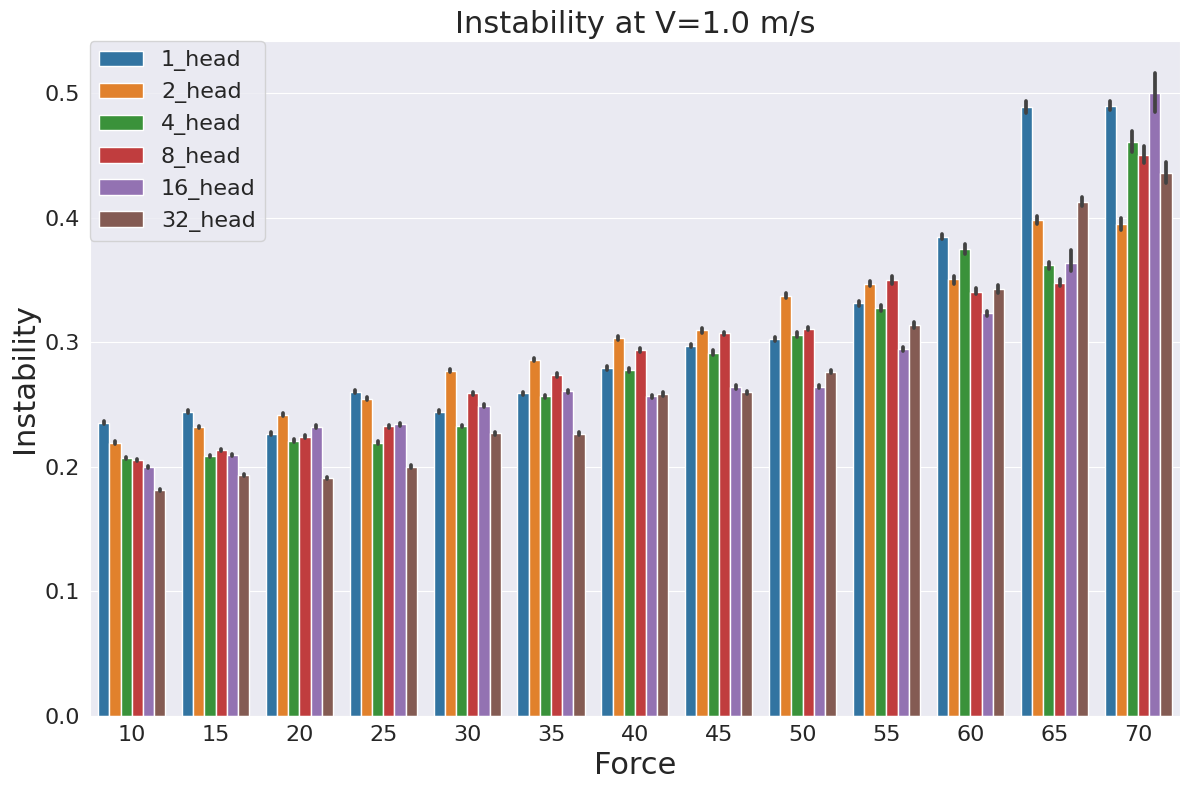

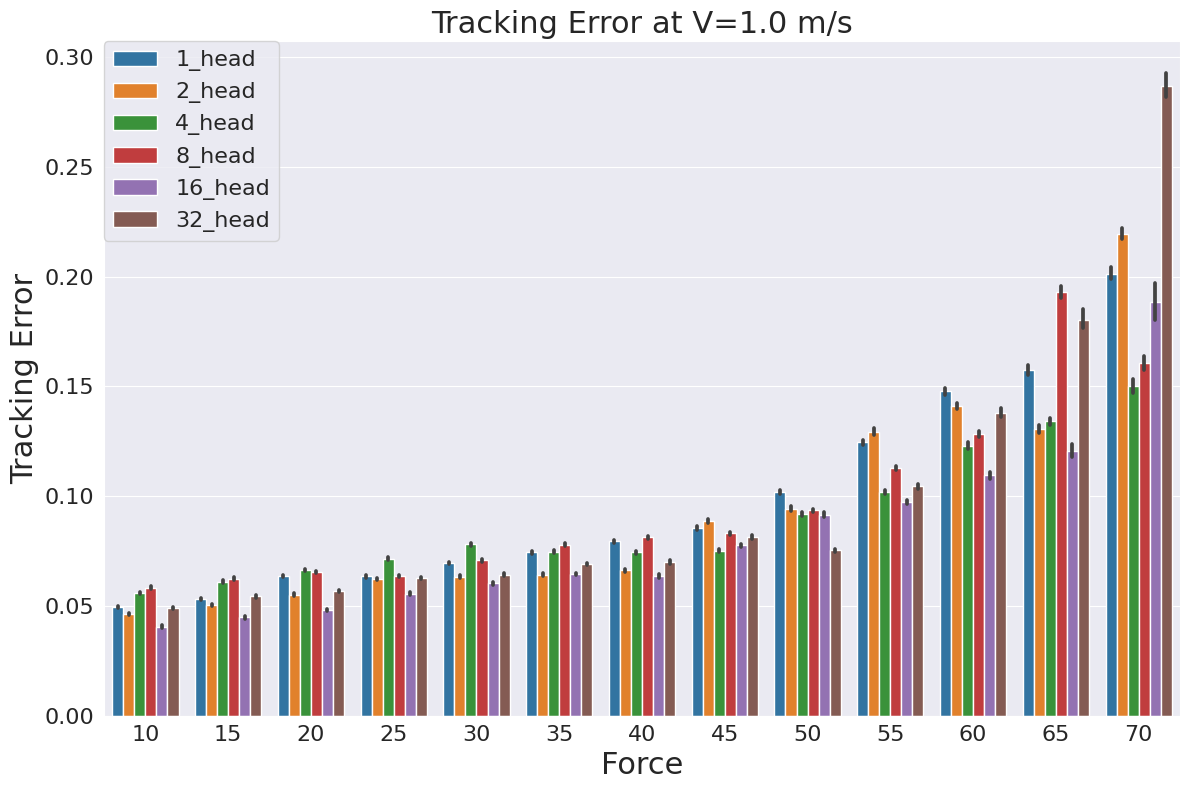

In [42]:
plot_iid_test(df, y_name='stability', x_name='force', 
              hue_name='name',
              y_label='Instability',
              x_label='Force', title=r'Instability at V=1.0 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ablation",
              save_name= 'ablation_stability_v10')

plot_iid_test(df, y_name='tracking_error', x_name='force', 
              hue_name='name',
              y_label='Tracking Error',
              x_label='Force', title=r'Tracking Error at V=1.0 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ablation",
              save_name= 'ablation_tracking_error_v10')

plot_iid_test(df, y_name='path_length', x_name='force', 
              hue_name='name',
              y_label='TTF',
              x_label='Force', title=r'TTF at V=1.0 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ablation",
              save_name= 'ablation_ttf_v10')

In [26]:
list_data_name = ['PPO','RMA','E-Net','Our Method']
force_values = [10,15,20,25,30,35,40,45,50,55,60,65,70]
include = ['VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']
list_data_name = ['1_head', '2_head', '4_head', '8_head', '16_head', '32_head']

# include = ['Expert', 'RMA', 'VQ_1_head',  'VQ_4_head', ]
# list_data_name = ['PPO', 'RMA', 'E-Net', 'Our Method']

dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval2/iid/v10/{force}N",include=include)
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)
print(df.describe())

result = df.groupby('name').agg({'stability': ['mean', 'std'],
                                 'tracking_error': ['mean', 'std'],
                                 'fall_rate': ['mean', 'std']})

result = result.round(2)

result.to_csv('data/eval2/ablation/iidv10.csv')

check data:  1_head VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v10-force-10N.npy
check data:  2_head VQ-VQ_2_head-stationary_push-VQ_2_head-iid_v10-force-10N.npy
check data:  4_head VQ-VQ_4_head-stationary_push-VQ_4_head-iid_v10-force-10N.npy
check data:  8_head VQ-VQ_8_head-stationary_push-VQ_8_head-iid_v10-force-10N.npy
check data:  16_head VQ-VQ_16_head-stationary_push-VQ_16_head-iid_v10-force-10N.npy
check data:  32_head VQ-VQ_32_head-stationary_push-VQ_32_head-iid_v10-force-10N.npy
check data:  1_head VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v10-force-15N.npy
check data:  2_head VQ-VQ_2_head-stationary_push-VQ_2_head-iid_v10-force-15N.npy
check data:  4_head VQ-VQ_4_head-stationary_push-VQ_4_head-iid_v10-force-15N.npy
check data:  8_head VQ-VQ_8_head-stationary_push-VQ_8_head-iid_v10-force-15N.npy
check data:  16_head VQ-VQ_16_head-stationary_push-VQ_16_head-iid_v10-force-15N.npy
check data:  32_head VQ-VQ_32_head-stationary_push-VQ_32_head-iid_v10-force-15N.npy
check data:  1_h

check data:  16_head VQ-VQ_16_head-stationary_push-VQ_16_head-iid_v10-force-30N.npy
check data:  32_head VQ-VQ_32_head-stationary_push-VQ_32_head-iid_v10-force-30N.npy
check data:  1_head VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v10-force-35N.npy
check data:  2_head VQ-VQ_2_head-stationary_push-VQ_2_head-iid_v10-force-35N.npy
check data:  4_head VQ-VQ_4_head-stationary_push-VQ_4_head-iid_v10-force-35N.npy
check data:  8_head VQ-VQ_8_head-stationary_push-VQ_8_head-iid_v10-force-35N.npy
check data:  16_head VQ-VQ_16_head-stationary_push-VQ_16_head-iid_v10-force-35N.npy
check data:  32_head VQ-VQ_32_head-stationary_push-VQ_32_head-iid_v10-force-35N.npy
check data:  1_head VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v10-force-40N.npy
check data:  2_head VQ-VQ_2_head-stationary_push-VQ_2_head-iid_v10-force-40N.npy
check data:  4_head VQ-VQ_4_head-stationary_push-VQ_4_head-iid_v10-force-40N.npy
check data:  8_head VQ-VQ_8_head-stationary_push-VQ_8_head-iid_v10-force-40N.npy
check data:  16_

In [27]:
list_data_name = ['PPO','RMA','E-Net','Our Method']
force_values = [5,10,15,20,25,30,35]
include = ['VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']
list_data_name = ['1_head', '2_head', '4_head', '8_head', '16_head', '32_head']

# include = ['Expert', 'RMA', 'VQ_1_head',  'VQ_4_head', ]
# list_data_name = ['PPO', 'RMA', 'E-Net', 'Our Method']

dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval2/2body/v05/{force}N",include=include)
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)
print(df.describe())

result = df.groupby('name').agg({'stability': ['mean', 'std'],
                                 'tracking_error': ['mean', 'std'],
                                 'fall_rate': ['mean', 'std']})

result = result.round(2)

result.to_csv('data/eval2/ablation/2bodyv05.csv')

######### 
list_data_name = ['PPO','RMA','E-Net','Our Method']
force_values = [5,10,15,20,25,30,35]
include = ['VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']
list_data_name = ['1_head', '2_head', '4_head', '8_head', '16_head', '32_head']

# include = ['Expert', 'RMA', 'VQ_1_head',  'VQ_4_head', ]
# list_data_name = ['PPO', 'RMA', 'E-Net', 'Our Method']

dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval2/2body/v10/{force}N",include=include)
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)
print(df.describe())

result = df.groupby('name').agg({'stability': ['mean', 'std'],
                                 'tracking_error': ['mean', 'std'],
                                 'fall_rate': ['mean', 'std']})

result = result.round(2)

result.to_csv('data/eval2/ablation/2bodyv10.csv')

check data:  1_head VQ-VQ_1_head-2BodyPush-VQ_1_head-2body_v05-force-5N.npy
check data:  2_head VQ-VQ_2_head-2BodyPush-VQ_2_head-2body_v05-force-5N.npy
check data:  4_head VQ-VQ_4_head-2BodyPush-VQ_4_head-2body_v05-force-5N.npy
check data:  8_head VQ-VQ_8_head-2BodyPush-VQ_8_head-2body_v05-force-5N.npy
check data:  16_head VQ-VQ_16_head-2BodyPush-VQ_16_head-2body_v05-force-5N.npy
check data:  32_head VQ-VQ_32_head-2BodyPush-VQ_32_head-2body_v05-force-5N.npy
check data:  1_head VQ-VQ_1_head-2BodyPush-VQ_1_head-2body_v05-force-10N.npy
check data:  2_head VQ-VQ_2_head-2BodyPush-VQ_2_head-2body_v05-force-10N.npy
check data:  4_head VQ-VQ_4_head-2BodyPush-VQ_4_head-2body_v05-force-10N.npy
check data:  8_head VQ-VQ_8_head-2BodyPush-VQ_8_head-2body_v05-force-10N.npy
check data:  16_head VQ-VQ_16_head-2BodyPush-VQ_16_head-2body_v05-force-10N.npy
check data:  32_head VQ-VQ_32_head-2BodyPush-VQ_32_head-2body_v05-force-10N.npy
check data:  1_head VQ-VQ_1_head-2BodyPush-VQ_1_head-2body_v05-force-1

check data:  1_head VQ-VQ_1_head-2BodyPush-VQ_1_head-2body_v05-force-25N.npy
check data:  2_head VQ-VQ_2_head-2BodyPush-VQ_2_head-2body_v05-force-25N.npy
check data:  4_head VQ-VQ_4_head-2BodyPush-VQ_4_head-2body_v05-force-25N.npy
check data:  8_head VQ-VQ_8_head-2BodyPush-VQ_8_head-2body_v05-force-25N.npy
check data:  16_head VQ-VQ_16_head-2BodyPush-VQ_16_head-2body_v05-force-25N.npy
check data:  32_head VQ-VQ_32_head-2BodyPush-VQ_32_head-2body_v05-force-25N.npy
check data:  1_head VQ-VQ_1_head-2BodyPush-VQ_1_head-2body_v05-force-30N.npy
check data:  2_head VQ-VQ_2_head-2BodyPush-VQ_2_head-2body_v05-force-30N.npy
check data:  4_head VQ-VQ_4_head-2BodyPush-VQ_4_head-2body_v05-force-30N.npy
check data:  8_head VQ-VQ_8_head-2BodyPush-VQ_8_head-2body_v05-force-30N.npy
check data:  16_head VQ-VQ_16_head-2BodyPush-VQ_16_head-2body_v05-force-30N.npy
check data:  32_head VQ-VQ_32_head-2BodyPush-VQ_32_head-2body_v05-force-30N.npy
check data:  1_head VQ-VQ_1_head-2BodyPush-VQ_1_head-2body_v05-f

In [28]:
list_data_name = ['PPO','RMA','E-Net','Our Method']
force_values = [5,10,15,20,25,30,35]
include = ['VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']
list_data_name = ['1_head', '2_head', '4_head', '8_head', '16_head', '32_head']

# include = ['Expert', 'RMA', 'VQ_1_head',  'VQ_4_head', ]
# list_data_name = ['PPO', 'RMA', 'E-Net', 'Our Method']

dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval2/3body/v05/{force}N",include=include)
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)
print(df.describe())

result = df.groupby('name').agg({'stability': ['mean', 'std'],
                                 'tracking_error': ['mean', 'std'],
                                 'fall_rate': ['mean', 'std']})

result = result.round(2)

result.to_csv('data/eval2/ablation/3bodyv05.csv')

######### 
list_data_name = ['PPO','RMA','E-Net','Our Method']
force_values = [5,10,15,20,25,30,35]
include = ['VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']
list_data_name = ['1_head', '2_head', '4_head', '8_head', '16_head', '32_head']

# include = ['Expert', 'RMA', 'VQ_1_head',  'VQ_4_head', ]
# list_data_name = ['PPO', 'RMA', 'E-Net', 'Our Method']

dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval2/3body/v10/{force}N",include=include)
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)
print(df.describe())

result = df.groupby('name').agg({'stability': ['mean', 'std'],
                                 'tracking_error': ['mean', 'std'],
                                 'fall_rate': ['mean', 'std']})

result = result.round(2)

result.to_csv('data/eval2/ablation/3bodyv10.csv')

check data:  1_head VQ-VQ_1_head-3BodyPush-VQ_1_head-3body_v05-force-5N.npy
check data:  2_head VQ-VQ_2_head-3BodyPush-VQ_2_head-3body_v05-force-5N.npy
check data:  4_head VQ-VQ_4_head-3BodyPush-VQ_4_head-3body_v05-force-5N.npy
check data:  8_head VQ-VQ_8_head-3BodyPush-VQ_8_head-3body_v05-force-5N.npy
check data:  16_head VQ-VQ_16_head-3BodyPush-VQ_16_head-3body_v05-force-5N.npy
check data:  32_head VQ-VQ_32_head-3BodyPush-VQ_32_head-3body_v05-force-5N.npy
check data:  1_head VQ-VQ_1_head-3BodyPush-VQ_1_head-3body_v05-force-10N.npy
check data:  2_head VQ-VQ_2_head-3BodyPush-VQ_2_head-3body_v05-force-10N.npy
check data:  4_head VQ-VQ_4_head-3BodyPush-VQ_4_head-3body_v05-force-10N.npy
check data:  8_head VQ-VQ_8_head-3BodyPush-VQ_8_head-3body_v05-force-10N.npy
check data:  16_head VQ-VQ_16_head-3BodyPush-VQ_16_head-3body_v05-force-10N.npy
check data:  32_head VQ-VQ_32_head-3BodyPush-VQ_32_head-3body_v05-force-10N.npy
check data:  1_head VQ-VQ_1_head-3BodyPush-VQ_1_head-3body_v05-force-1

## V = 0.5

In [31]:
list_data_name = ['PPO','RMA','E-Net','Our Method']
force_values = [10,15,20,25,30,35,40,45,50,55,60,65,70]
# include = ['Expert', 'RMA', 'VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']
# list_data_name = ['Expert', 'RMA', 'VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']

include = ['Expert', 'RMA', 'VQ_1_head',  'VQ_4_head', ]
list_data_name = ['PPO', 'RMA', 'E-Net', 'Our Method']

dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval2/iid/v05/{force}N",include=include)
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)
print(df.describe())

check data:  PPO Expert-PushBaseline-stationary_push-expert-iid_v05-force-10N.npy
check data:  RMA RMA-PushBaseline-stationary_push-rma-iid_v05-force-10N.npy
check data:  E-Net VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v05-force-10N.npy
check data:  Our Method VQ-VQ_4_head-stationary_push-VQ_4_head-iid_v05-force-10N.npy
check data:  PPO Expert-PushBaseline-stationary_push-expert-iid_v05-force-15N.npy
check data:  RMA RMA-PushBaseline-stationary_push-rma-iid_v05-force-15N.npy
check data:  E-Net VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v05-force-15N.npy
check data:  Our Method VQ-VQ_4_head-stationary_push-VQ_4_head-iid_v05-force-15N.npy
check data:  PPO Expert-PushBaseline-stationary_push-expert-iid_v05-force-20N.npy
check data:  RMA RMA-PushBaseline-stationary_push-rma-iid_v05-force-20N.npy
check data:  E-Net VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v05-force-20N.npy
check data:  Our Method VQ-VQ_4_head-stationary_push-VQ_4_head-iid_v05-force-20N.npy
check data:  PPO Expert-PushBas

check data:  PPO Expert-PushBaseline-stationary_push-expert-iid_v05-force-50N.npy
check data:  RMA RMA-PushBaseline-stationary_push-rma-iid_v05-force-50N.npy
check data:  E-Net VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v05-force-50N.npy
check data:  Our Method VQ-VQ_4_head-stationary_push-VQ_4_head-iid_v05-force-50N.npy
check data:  PPO Expert-PushBaseline-stationary_push-expert-iid_v05-force-55N.npy
check data:  RMA RMA-PushBaseline-stationary_push-rma-iid_v05-force-55N.npy
check data:  E-Net VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v05-force-55N.npy
check data:  Our Method VQ-VQ_4_head-stationary_push-VQ_4_head-iid_v05-force-55N.npy
check data:  PPO Expert-PushBaseline-stationary_push-expert-iid_v05-force-60N.npy
check data:  RMA RMA-PushBaseline-stationary_push-rma-iid_v05-force-60N.npy
check data:  E-Net VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v05-force-60N.npy
check data:  Our Method VQ-VQ_4_head-stationary_push-VQ_4_head-iid_v05-force-60N.npy
check data:  PPO Expert-PushBas

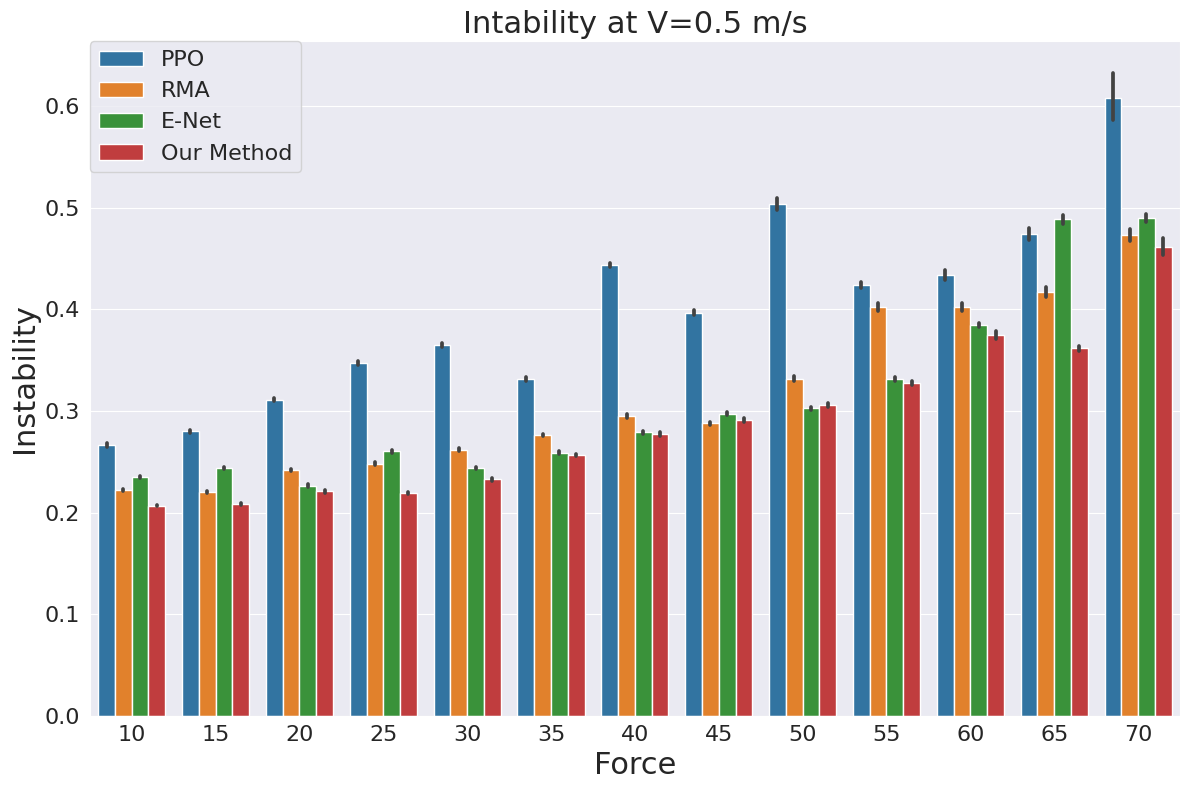

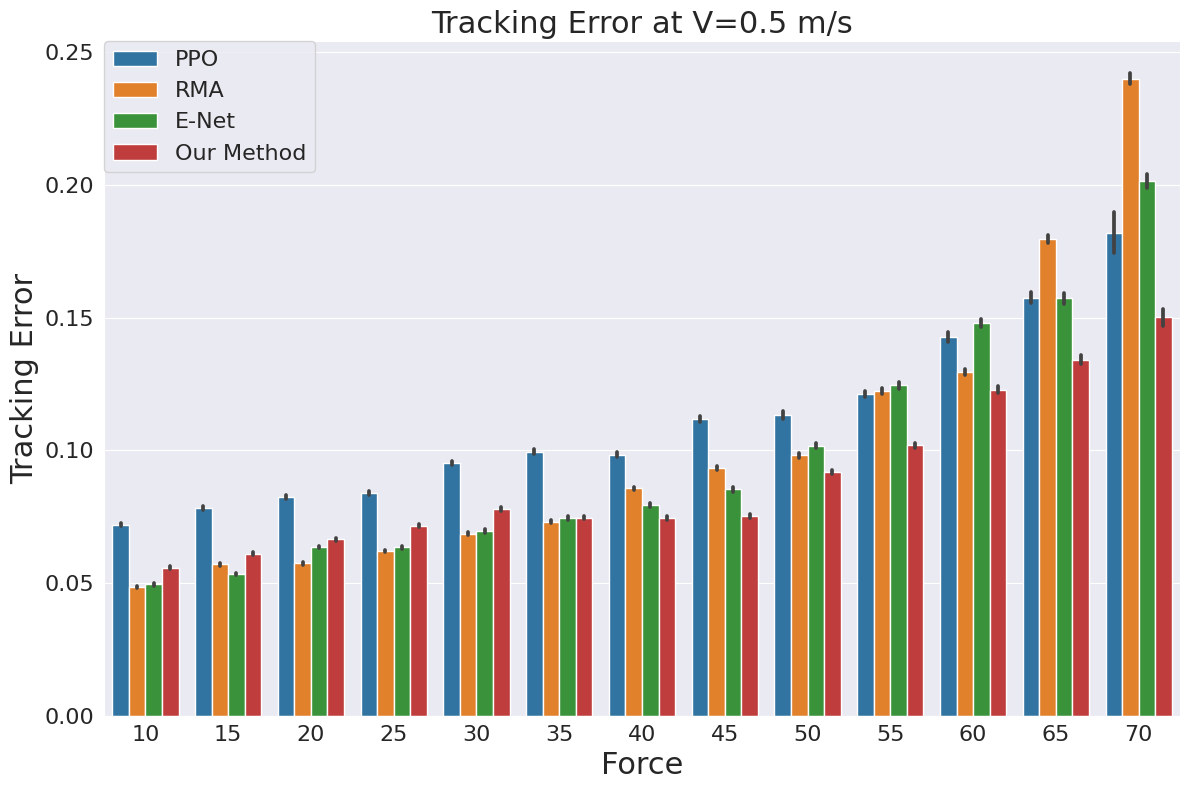

In [32]:
plot_iid_test(df, y_name='stability', x_name='force', 
              hue_name='name',
              y_label='Instability',
              x_label='Force', title=r'Intability at V=0.5 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/iid",
              save_name= 'iid_stability_v05')

plot_iid_test(df, y_name='tracking_error', x_name='force', 
              hue_name='name',
              y_label='Tracking Error',
              x_label='Force', title=r'Tracking Error at V=0.5 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/iid",
              save_name= 'iid_tracking_error_v05')

plot_iid_test(df, y_name='path_length', x_name='force', 
              hue_name='name',
              y_label='TTF',
              x_label='Force', title=r'TTF at V=0.5 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/iid",
              save_name= 'iid_ttf_v05')

## V = 1.0

In [33]:
list_data_name = ['PPO','RMA','E-Net','Our Method']
force_values = [10,15,20,25,30,35,40,45,50,55,60,65,70]
# include = ['Expert', 'RMA', 'VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']
# list_data_name = ['Expert', 'RMA', 'VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']

include = ['Expert', 'RMA', 'VQ_1_head',  'VQ_16_head']
list_data_name = ['PPO', 'RMA', 'E-Net','Our Method']

dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval2/iid/v10/{force}N",include=include)
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)
print(df.describe())

check data:  PPO Expert-PushBaseline-stationary_push-expert-iid_v10-force-10N.npy
check data:  RMA RMA-PushBaseline-stationary_push-rma-iid_v10-force-10N.npy
check data:  E-Net VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v10-force-10N.npy
check data:  Our Method VQ-VQ_16_head-stationary_push-VQ_16_head-iid_v10-force-10N.npy
check data:  PPO Expert-PushBaseline-stationary_push-expert-iid_v10-force-15N.npy
check data:  RMA RMA-PushBaseline-stationary_push-rma-iid_v10-force-15N.npy
check data:  E-Net VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v10-force-15N.npy
check data:  Our Method VQ-VQ_16_head-stationary_push-VQ_16_head-iid_v10-force-15N.npy
check data:  PPO Expert-PushBaseline-stationary_push-expert-iid_v10-force-20N.npy
check data:  RMA RMA-PushBaseline-stationary_push-rma-iid_v10-force-20N.npy
check data:  E-Net VQ-VQ_1_head-stationary_push-VQ_1_head-iid_v10-force-20N.npy
check data:  Our Method VQ-VQ_16_head-stationary_push-VQ_16_head-iid_v10-force-20N.npy
check data:  PPO Expert-P

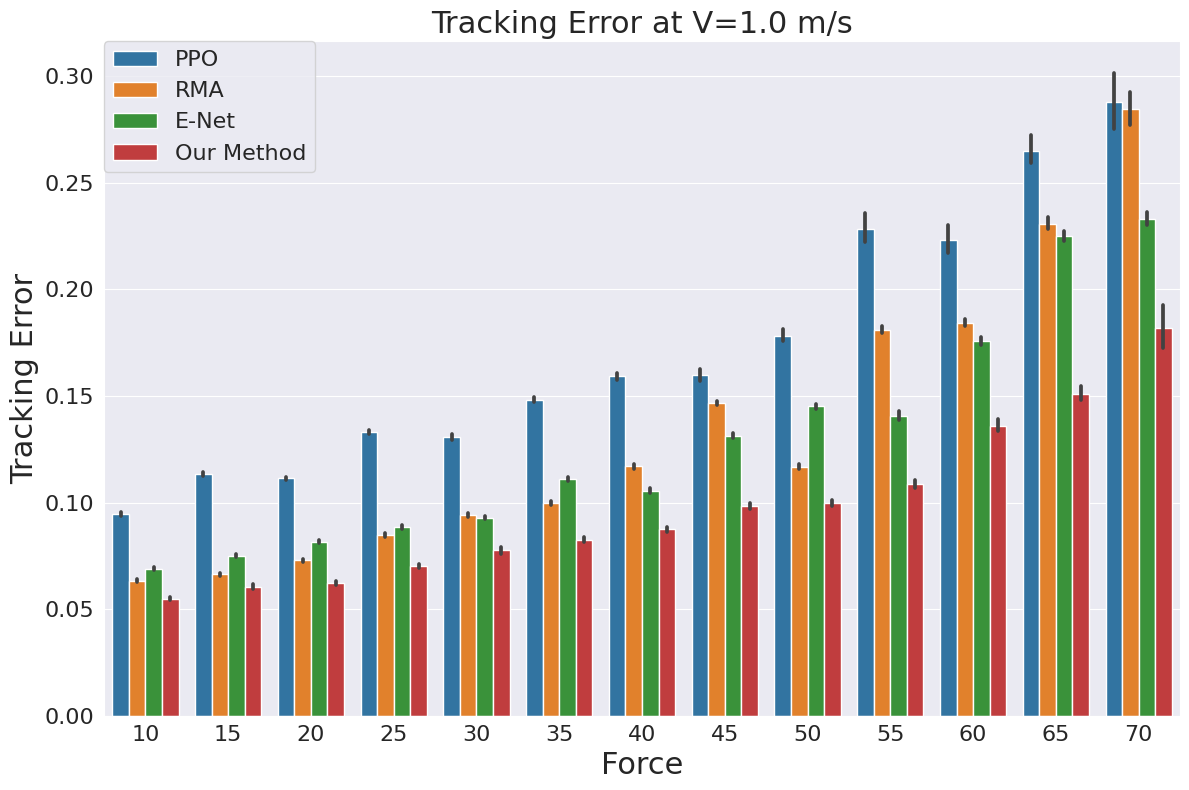

In [35]:
plot_iid_test(df, y_name='stability', x_name='force', 
              hue_name='name',
              y_label='Instability',
              x_label='Force', title=r'Instability at V=1.0 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/iid",
              save_name= 'iid_instability_v10')

plot_iid_test(df, y_name='tracking_error', x_name='force', 
              hue_name='name',
              y_label='Tracking Error',
              x_label='Force', title=r'Tracking Error at V=1.0 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/iid",
              save_name= 'iid_tracking_error_v10')

plot_iid_test(df, y_name='path_length', x_name='force', 
              hue_name='name',
              y_label='TTF',
              x_label='Force', title=r'TTF at V=1.0 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/iid",
              save_name= 'iid_ttf_v10')

# 组合泛化测试 

## 2 Body

### V=0.5

In [23]:
list_data_name = ['PPO','RMA','E-Net','Our Method']
force_values = [10,15,20,25,30,35]
# include = ['Expert', 'RMA', 'VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']
# list_data_name = ['Expert', 'RMA', 'VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']

include = ['Expert', 'RMA', 'VQ_1_head', 'VQ_16_head']
list_data_name = ['PPO','RMA','E-Net','Our Method']

dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval2/2body/v05/{force}N",include=include)
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)
print(df.describe())

check data:  PPO Expert-PushBaseline-2BodyPush-expert-2body_v05-force-10N.npy
check data:  RMA RMA-PushBaseline-2BodyPush-rma-2body_v05-force-10N.npy
check data:  E-Net VQ-VQ_1_head-2BodyPush-VQ_1_head-2body_v05-force-10N.npy
check data:  Our Method VQ-VQ_16_head-2BodyPush-VQ_16_head-2body_v05-force-10N.npy
check data:  PPO Expert-PushBaseline-2BodyPush-expert-2body_v05-force-15N.npy
check data:  RMA RMA-PushBaseline-2BodyPush-rma-2body_v05-force-15N.npy
check data:  E-Net VQ-VQ_1_head-2BodyPush-VQ_1_head-2body_v05-force-15N.npy
check data:  Our Method VQ-VQ_16_head-2BodyPush-VQ_16_head-2body_v05-force-15N.npy
check data:  PPO Expert-PushBaseline-2BodyPush-expert-2body_v05-force-20N.npy
check data:  RMA RMA-PushBaseline-2BodyPush-rma-2body_v05-force-20N.npy
check data:  E-Net VQ-VQ_1_head-2BodyPush-VQ_1_head-2body_v05-force-20N.npy
check data:  Our Method VQ-VQ_16_head-2BodyPush-VQ_16_head-2body_v05-force-20N.npy
check data:  PPO Expert-PushBaseline-2BodyPush-expert-2body_v05-force-25N

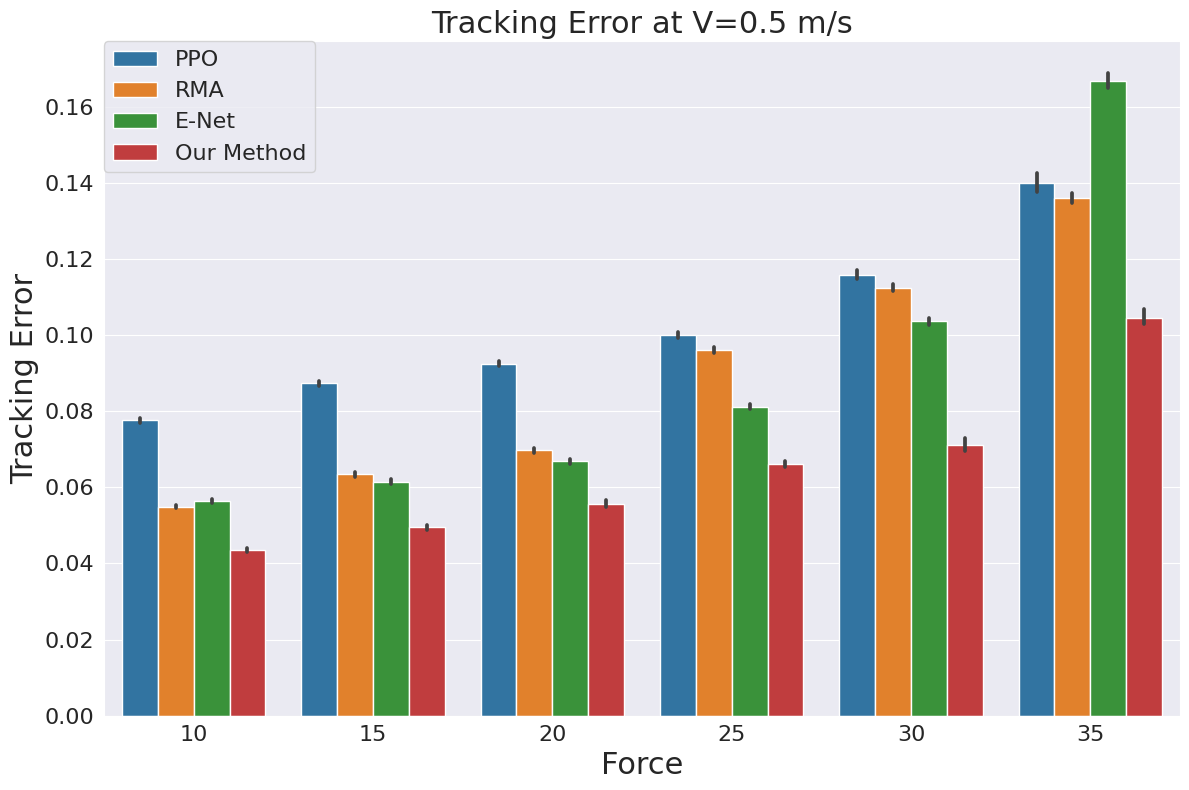

In [24]:
plot_iid_test(df, y_name='stability', x_name='force', 
              hue_name='name',
              y_label='Instability',
              x_label='Force', title=r'Instability at V=0.5 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ood",
              save_name= 'ood2body_instability_v05')

plot_iid_test(df, y_name='tracking_error', x_name='force', 
              hue_name='name',
              y_label='Tracking Error',
              x_label='Force', title=r'Tracking Error at V=0.5 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ood",
              save_name= 'ood2body_tracking_error_v05')

plot_iid_test(df, y_name='path_length', x_name='force', 
              hue_name='name',
              y_label='TTF',
              x_label='Force', title=r'TTF at V=0.5 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ood",
              save_name= 'ood2body_ttf_v05')

### V=1.0

In [25]:
list_data_name = ['PPO','RMA','E-Net','Our Method']
force_values = [10,15,20,25,30,35]
include = ['Expert', 'RMA', 'VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']
list_data_name = ['Expert', 'RMA', 'VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']

include = ['Expert', 'RMA', 'VQ_1_head', 'VQ_16_head',]
list_data_name = ['PPO','RMA','E-Net','Our Method']

dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval2/2body/v10/{force}N",include=include)
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)
print(df.describe())

check data:  PPO Expert-PushBaseline-2BodyPush-expert-2body_v10-force-10N.npy
check data:  RMA RMA-PushBaseline-2BodyPush-rma-2body_v10-force-10N.npy
check data:  E-Net VQ-VQ_1_head-2BodyPush-VQ_1_head-2body_v10-force-10N.npy
check data:  Our Method VQ-VQ_16_head-2BodyPush-VQ_16_head-2body_v10-force-10N.npy
check data:  PPO Expert-PushBaseline-2BodyPush-expert-2body_v10-force-15N.npy
check data:  RMA RMA-PushBaseline-2BodyPush-rma-2body_v10-force-15N.npy
check data:  E-Net VQ-VQ_1_head-2BodyPush-VQ_1_head-2body_v10-force-15N.npy
check data:  Our Method VQ-VQ_16_head-2BodyPush-VQ_16_head-2body_v10-force-15N.npy
check data:  PPO Expert-PushBaseline-2BodyPush-expert-2body_v10-force-20N.npy
check data:  RMA RMA-PushBaseline-2BodyPush-rma-2body_v10-force-20N.npy
check data:  E-Net VQ-VQ_1_head-2BodyPush-VQ_1_head-2body_v10-force-20N.npy
check data:  Our Method VQ-VQ_16_head-2BodyPush-VQ_16_head-2body_v10-force-20N.npy
check data:  PPO Expert-PushBaseline-2BodyPush-expert-2body_v10-force-25N

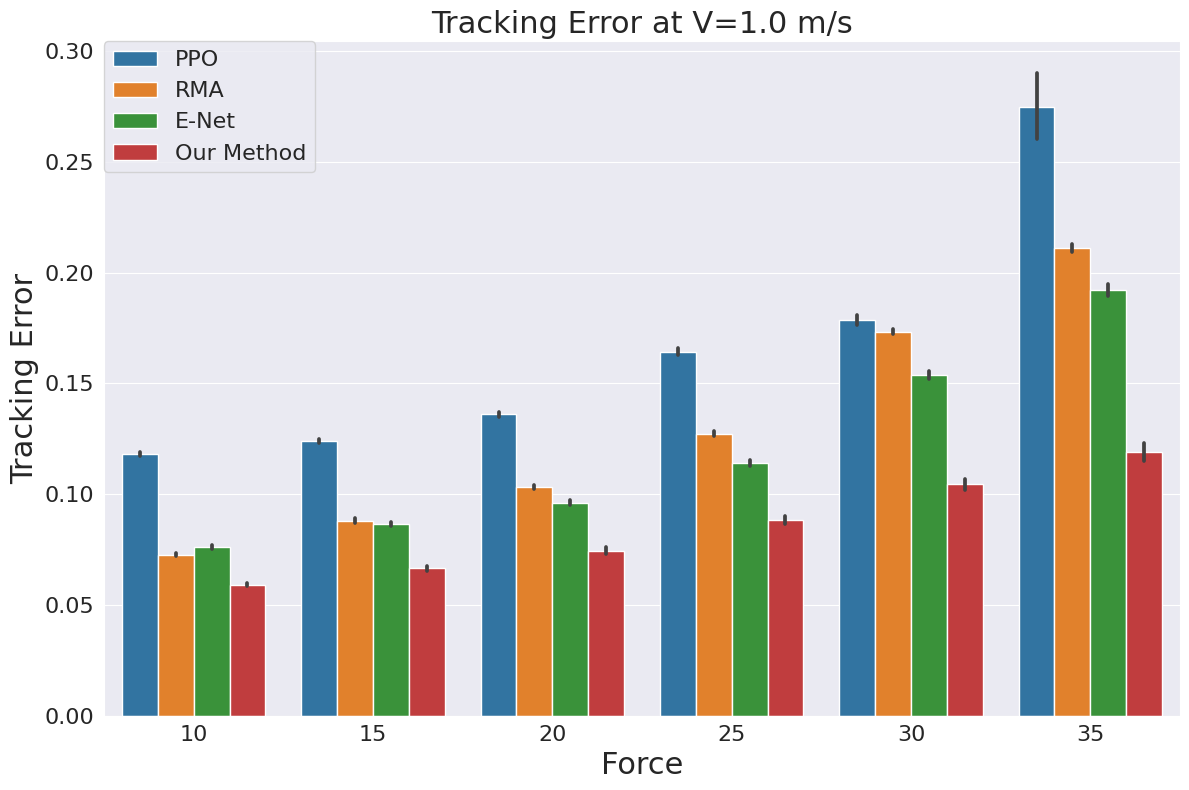

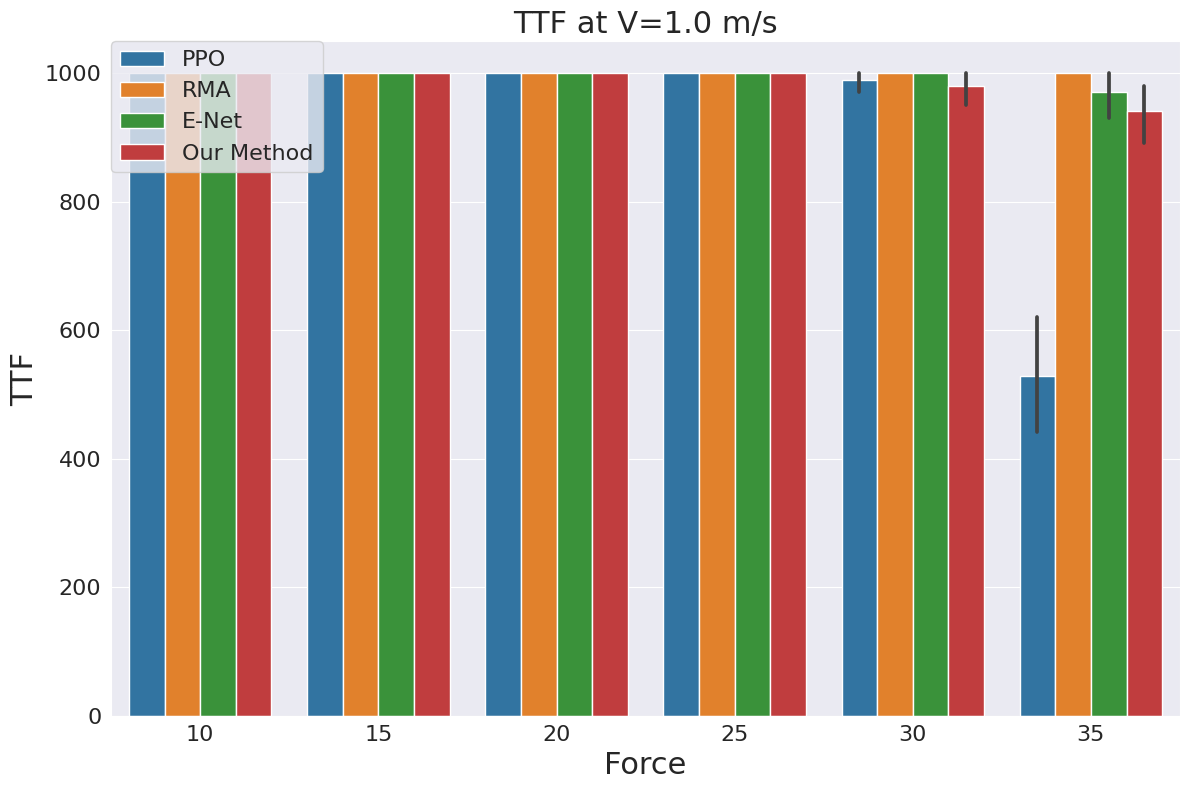

In [26]:
plot_iid_test(df, y_name='stability', x_name='force', 
              hue_name='name',
              y_label='Instability',
              x_label='Force', title=r'Instability at V=1.0 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ood",
              save_name= 'ood2body_instability_v10')

plot_iid_test(df, y_name='tracking_error', x_name='force', 
              hue_name='name',
              y_label='Tracking Error',
              x_label='Force', title=r'Tracking Error at V=1.0 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ood",
              save_name= 'ood2body_tracking_error_v10')

plot_iid_test(df, y_name='path_length', x_name='force', 
              hue_name='name',
              y_label='TTF',
              x_label='Force', title=r'TTF at V=1.0 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ood",
              save_name= 'ood2body_ttf_v10')

# 3 Body

## V = 0.5

In [27]:
list_data_name = ['PPO','RMA','E-Net','Our Method']
force_values = [10,15,20,25,30,35]
# include = ['Expert', 'RMA', 'VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']
# list_data_name = ['Expert', 'RMA', 'VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']

include = ['Expert', 'RMA', 'VQ_1_head', 'VQ_16_head']
list_data_name = ['PPO','RMA','E-Net','Our Method']
dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval2/3body/v05/{force}N",include=include)
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)
print(df.describe())

check data:  PPO Expert-PushBaseline-3BodyPush-expert-3body_v05-force-10N.npy
check data:  RMA RMA-PushBaseline-3BodyPush-rma-3body_v05-force-10N.npy
check data:  E-Net VQ-VQ_1_head-3BodyPush-VQ_1_head-3body_v05-force-10N.npy
check data:  Our Method VQ-VQ_16_head-3BodyPush-VQ_16_head-3body_v05-force-10N.npy
check data:  PPO Expert-PushBaseline-3BodyPush-expert-3body_v05-force-15N.npy
check data:  RMA RMA-PushBaseline-3BodyPush-rma-3body_v05-force-15N.npy
check data:  E-Net VQ-VQ_1_head-3BodyPush-VQ_1_head-3body_v05-force-15N.npy
check data:  Our Method VQ-VQ_16_head-3BodyPush-VQ_16_head-3body_v05-force-15N.npy
check data:  PPO Expert-PushBaseline-3BodyPush-expert-3body_v05-force-20N.npy
check data:  RMA RMA-PushBaseline-3BodyPush-rma-3body_v05-force-20N.npy
check data:  E-Net VQ-VQ_1_head-3BodyPush-VQ_1_head-3body_v05-force-20N.npy
check data:  Our Method VQ-VQ_16_head-3BodyPush-VQ_16_head-3body_v05-force-20N.npy
check data:  PPO Expert-PushBaseline-3BodyPush-expert-3body_v05-force-25N

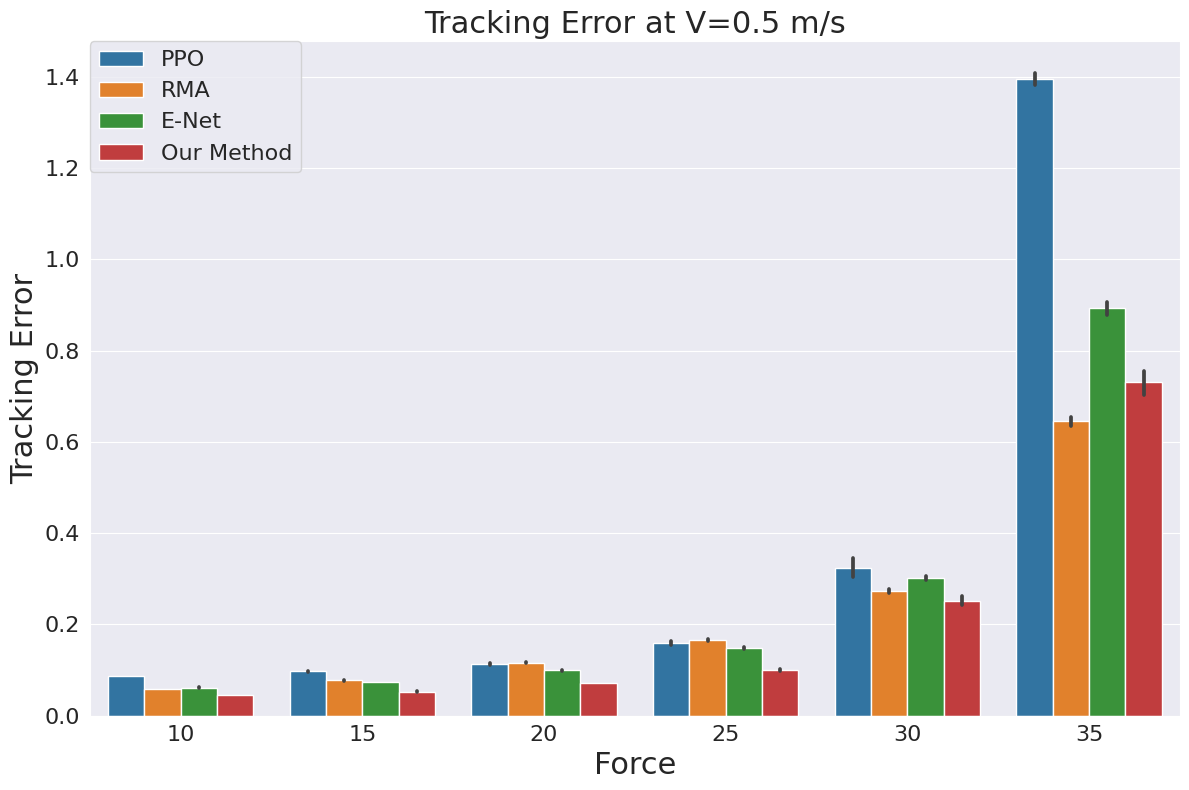

In [28]:
plot_iid_test(df, y_name='stability', x_name='force', 
              hue_name='name',
              y_label='Instability',
              x_label='Force', title=r'Instability at V=0.5 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ood",
              save_name= 'ood3body_instability_v05')

plot_iid_test(df, y_name='tracking_error', x_name='force', 
              hue_name='name',
              y_label='Tracking Error',
              x_label='Force', title=r'Tracking Error at V=0.5 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ood",
              save_name= 'ood3body_tracking_error_v05')

plot_iid_test(df, y_name='path_length', x_name='force', 
              hue_name='name',
              y_label='TTF',
              x_label='Force', title=r'TTF at V=0.5 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ood",
              save_name= 'ood3body_ttf_v05')

## V = 1.0

In [29]:
list_data_name = ['PPO','RMA','E-Net','Our Method']
force_values = [10,15,20,25,30,35]
# include = ['Expert', 'RMA', 'VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']
# list_data_name = ['Expert', 'RMA', 'VQ_1_head', 'VQ_2_head', 'VQ_4_head', 'VQ_8_head', 'VQ_16_head', 'VQ_32_head']

include = ['Expert', 'RMA', 'VQ_1_head', 'VQ_16_head']
list_data_name = ['PPO','RMA','E-Net','Our Method']

dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval2/3body/v10/{force}N",include=include)
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)
print(df.describe())

check data:  PPO Expert-PushBaseline-3BodyPush-expert-3body_v10-force-10N.npy
check data:  RMA RMA-PushBaseline-3BodyPush-rma-3body_v10-force-10N.npy
check data:  E-Net VQ-VQ_1_head-3BodyPush-VQ_1_head-3body_v10-force-10N.npy
check data:  Our Method VQ-VQ_16_head-3BodyPush-VQ_16_head-3body_v10-force-10N.npy
check data:  PPO Expert-PushBaseline-3BodyPush-expert-3body_v10-force-15N.npy
check data:  RMA RMA-PushBaseline-3BodyPush-rma-3body_v10-force-15N.npy
check data:  E-Net VQ-VQ_1_head-3BodyPush-VQ_1_head-3body_v10-force-15N.npy
check data:  Our Method VQ-VQ_16_head-3BodyPush-VQ_16_head-3body_v10-force-15N.npy
check data:  PPO Expert-PushBaseline-3BodyPush-expert-3body_v10-force-20N.npy
check data:  RMA RMA-PushBaseline-3BodyPush-rma-3body_v10-force-20N.npy
check data:  E-Net VQ-VQ_1_head-3BodyPush-VQ_1_head-3body_v10-force-20N.npy
check data:  Our Method VQ-VQ_16_head-3BodyPush-VQ_16_head-3body_v10-force-20N.npy
check data:  PPO Expert-PushBaseline-3BodyPush-expert-3body_v10-force-25N

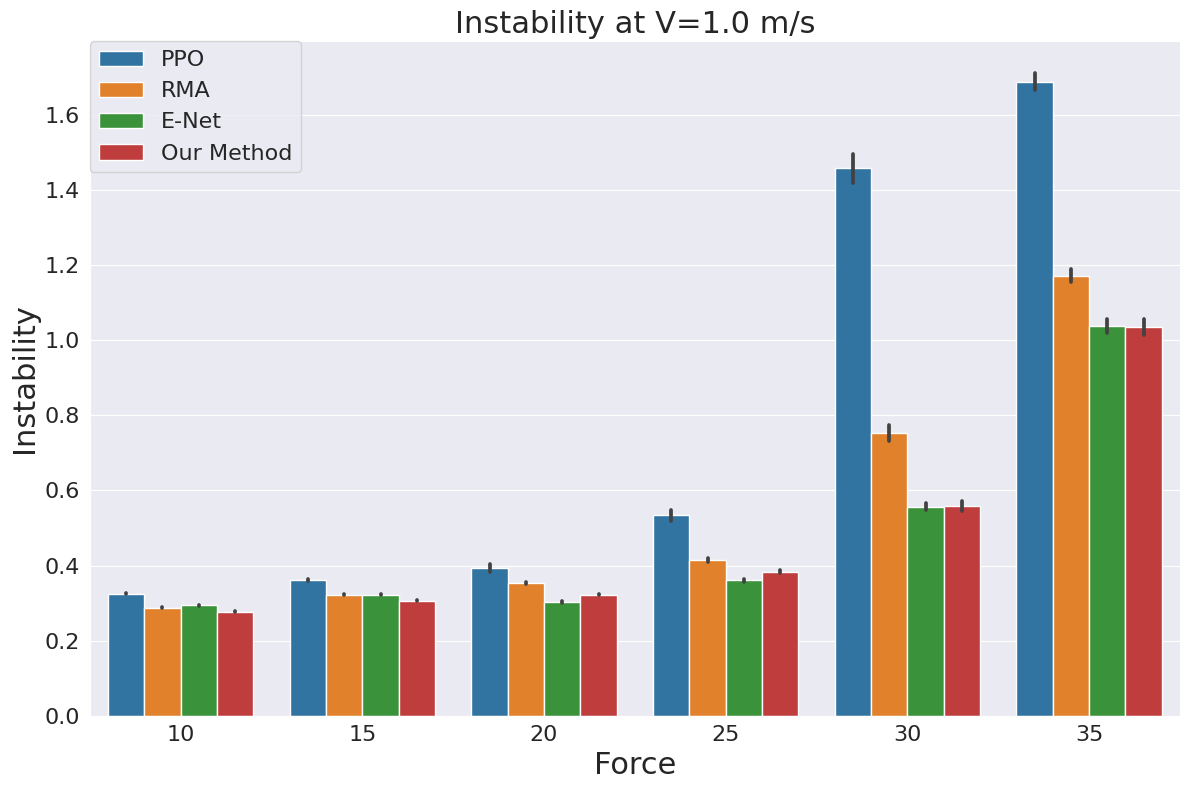

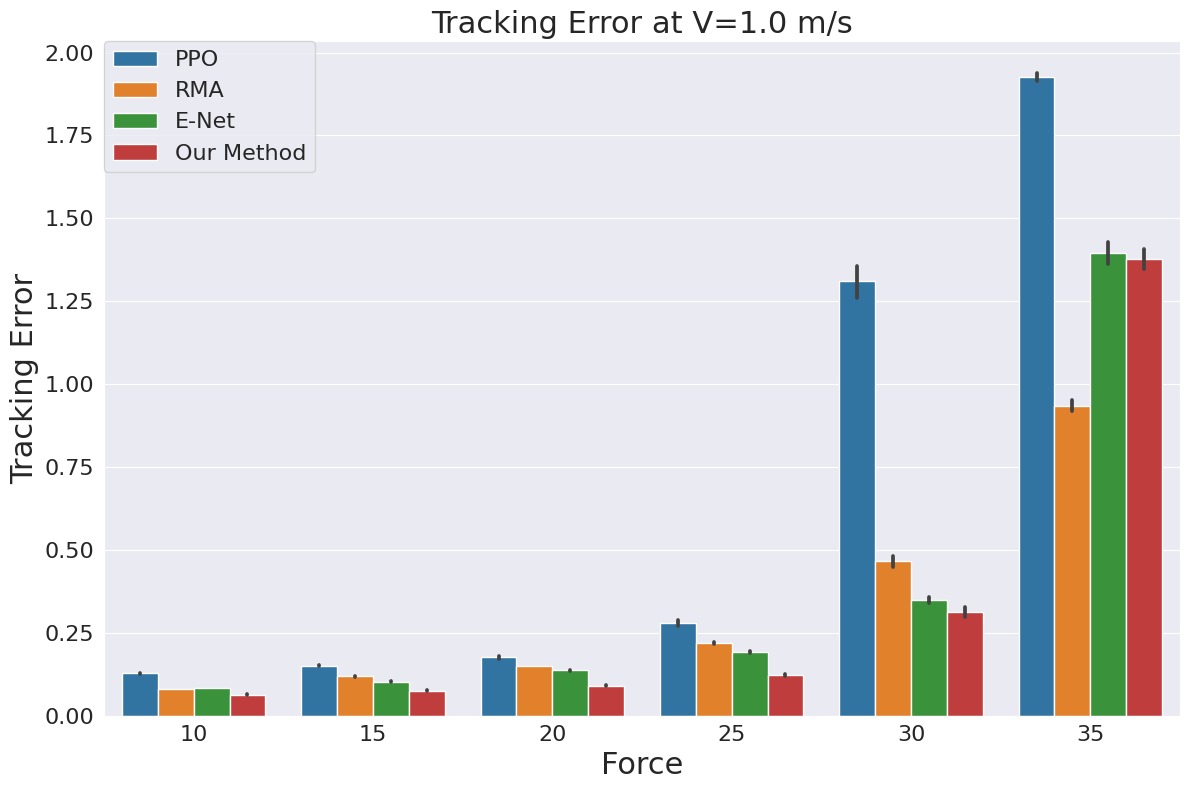

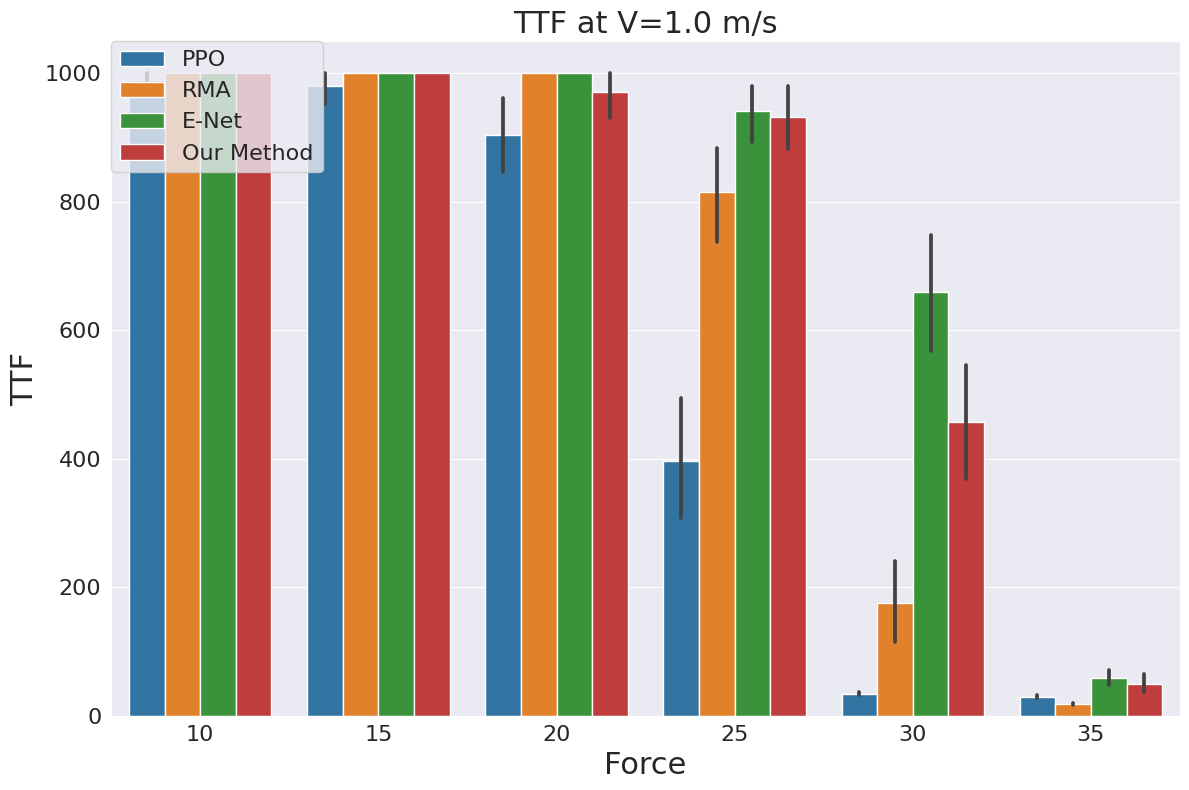

In [30]:
plot_iid_test(df, y_name='stability', x_name='force', 
              hue_name='name',
              y_label='Instability',
              x_label='Force', title=r'Instability at V=1.0 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ood",
              save_name= 'ood3body_instability_v10')

plot_iid_test(df, y_name='tracking_error', x_name='force', 
              hue_name='name',
              y_label='Tracking Error',
              x_label='Force', title=r'Tracking Error at V=1.0 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ood",
              save_name= 'ood3body_tracking_error_v10')

plot_iid_test(df, y_name='path_length', x_name='force', 
              hue_name='name',
              y_label='TTF',
              x_label='Force', title=r'TTF at V=1.0 m/s',
              remove_outliers=False,
              plot_type='bar',
              save_path= "data/eval2/ood",
              save_name= 'ood3body_ttf_v10')

# 步态分析

In [27]:
def get_contact_data(path, 
                     start_step = 0, end_step = 500,
                     agent_id = 0,force_threshold = 1):
    data = load_data(path)
    res = {}
    name = data['name']
    n_agent = len(data['first_done']) 
    res['eval_name'] = name
    applied_force = data['force'][0] # shape = (n_step, n_body, 3)
    n_body_force = np.abs(applied_force).sum(-1) # shape = (n_step,n_body)
    n_step_count = ( n_body_force > 0 ).sum(-1) # shape = (n_step)
    n_force = np.max(n_step_count) 
    print("N force ", n_force) 

    i = agent_id
    first_done = data['first_done'][i]
    contact_force_z = data['contact_force_z'][i][0: first_done]
    applied_force = data['force'][i][0: first_done]
    base_vel = data['base_vel'][i][0: first_done]
    base_vel_roll = data['base_vel_roll'][i][0: first_done]
    body_index = []
    for i in range(first_done):
        f = np.abs(applied_force[i]).sum(-1) # (n_body,3)
        body_index.append(np.argwhere(f > 0).reshape(-1))
    body_index = np.concatenate(body_index,axis=0) # (n_step, n_body)
    contacts = np.where(contact_force_z > force_threshold, 1.0, 0.0) # (n_step,4)
    # force_change_points = np.where(np.abs(np.diff(np.abs(applied_force))).sum((-1,-2)) > 0.1, 1.0, 0.0)
    
    res['base_vel_x'] = base_vel[start_step:end_step,0]
    res['base_vel_y'] = base_vel[start_step:end_step,1]
    res['base_vel_z'] = base_vel[start_step:end_step,2]
    res['base_vel_roll'] = base_vel_roll[start_step:end_step]
    res['contact'] = contacts[start_step:end_step]
    res['force'] = applied_force[start_step:end_step]
    res['body_index'] = body_index[start_step:end_step]


    bd_idx = res['body_index'] # (n_step, n_body)
    diff_bd_idx = np.diff(bd_idx,axis=0) # (n_step-1, n_body)
    force_change_points = np.where(np.abs(diff_bd_idx) > 0)[0]
    # print(force_change_points)
    res['change_points'] = force_change_points + start_step

    selected_force = []
    for j in range(res['body_index'].shape[0]):
        index = body_index[j]
        selected_force.append(res['force'][j,index])
    selected_force = np.array(selected_force)
    res['applied_force'] = selected_force
    return res  

def prepare_sequential_data(list_data_path, start_step = 0, end_step = 500, agent_id = 0, force_threshold = 1):
    list_vel_x, list_vel_z, list_vel_roll = [],[],[]    
    for i in range(len(list_data_path)):
        data = get_contact_data(list_data_path[i], start_step = start_step, end_step = end_step, agent_id = agent_id, force_threshold = force_threshold) 
        list_vel_x.append(data['base_vel_x'])
        list_vel_z.append(data['base_vel_z'])
        list_vel_roll.append(data['base_vel_roll'])
        change_points = data['change_points']

    return list_vel_x, list_vel_z, list_vel_roll,change_points


In [28]:

def sequential_compare(
        list_vel_x, list_vel_z, list_vel_roll,list_name, start_step, change_points, dt=0.02,
                    title=None, title_fontsize=12, xlabel_fontsize=12, ylabel_fontsize=12,
                    save_path=None, subplot_spacing=0.4,xtick_fontsize = 12,
                    save_name = 'SequentialCompare'):
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(3, 1, figsize=(8, 4), sharex=True)
    n_step = list_vel_x[0].shape[0]
    time = (np.arange(n_step) + start_step) * dt
    #! vel_x
    for name,vel in zip(list_name,list_vel_x):
        axs[0].plot(time, vel, label=name,linewidth = 1,alpha = 0.8)
    for change_point in change_points:
        if change_point:
            axs[0].axvline((change_point + start_step) * dt, color='tab:red', linestyle='dashed')
        # axs[0].axvline(change_point * dt, color='tab:red', linestyle='dashed')
    axs[0].set_ylabel(r'$\dot{x}$', fontsize=ylabel_fontsize)
    axs[0].set_ylim([-0.2, 1.5])
    # axs[0].grid()
    axs[0].legend(frameon=True,loc=2, bbox_to_anchor=(1.01,-0.4),borderaxespad = 0.,fontsize = 10)
    axs[0].tick_params(axis='both', labelsize=xtick_fontsize)
    #! vel_z 
    for name, data in zip(list_name,list_vel_z):
        axs[1].plot(time, data, label=name,linewidth = 1,alpha = 0.8)
    axs[1].set_ylabel(r'$\dot{z}$', fontsize=ylabel_fontsize)
    axs[1].tick_params(axis='both', labelsize=xtick_fontsize)
    # axs[1].grid()

    # axs[1].legend_.remove()
    for change_point in change_points:
        if change_point:
            axs[1].axvline((change_point + start_step) * dt, color='tab:red', linestyle='dashed')

    #! vel_roll
    for name, data in zip(list_name,list_vel_roll):
        axs[2].plot(time, data, label=name,linewidth = 1,alpha = 0.8)
    axs[2].set_ylabel(r'$\theta_r$', fontsize=ylabel_fontsize)
    # axs[2].grid()
    # axs[2].legend_.remove()
    for change_point in change_points:
        if change_point :
            axs[2].axvline((change_point + start_step) * dt, color='tab:red', linestyle='dashed')
    axs[2].tick_params(axis='both', labelsize=xtick_fontsize)
    axs[-1].set_xlabel('Time (s)',fontsize = xlabel_fontsize)
    # Set plot title with fontsize
    if title:
        plt.suptitle(title, fontsize=title_fontsize)

    plt.tight_layout()
    # plt.legend(frameon=True)
    # Adjust subplot spacing
    plt.subplots_adjust(hspace=subplot_spacing)

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path + f'/{save_name}.pdf', bbox_inches='tight')
    else:
        plt.show()

In [29]:
def visualize_legged_robot_contacts(contacts, args=['FL', 'FR', 'RL', 'RR'],change_points = None,start_step =0,
                                    xlim=None, title=None,
                                    title_fontsize=20, dt=0.02,xlabel_fontsize=20,ylabel_fontsize=20,xtick_fontsize=18,
                                    y_spacing=0.2, save_path=None,save_name = 'ContactState', filter_window_size=None):
    # Create a new figure
    # sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(16,3))
    start_time = start_step * dt
    n_step = contacts.shape[0]
    # Define a colormap for leg colors
    leg_colors = {
        'FL': 'r',
        'FR': 'b',
        'RL': 'g',
        'RR': 'grey'
    }

    y_positions = {}  # Dictionary to store y-positions for each leg
    for leg in args:
        y_positions[leg] = y_spacing * (args.index(leg) + 1)

    for leg in args:
        leg_contact = contacts[:, args.index(leg)]  # Extract contact values for the leg

        color = leg_colors.get(leg, 'gray')  # Use gray color if leg name not found

        # Plot contact values as horizontal bars
        for t in range(len(leg_contact)):
            if leg_contact[t] == 1:
                ax.plot([t * dt + start_time, (t + 1) * dt + start_time], [y_positions[leg], y_positions[leg]], color=color, lw=20)
            else:
                ax.plot([t * dt + start_time, (t + 1) * dt + start_time], [y_positions[leg], y_positions[leg]], color='white', lw=20)
    if change_points is not None:
        for change_point in change_points:
            # if change_point > start_step and change_point <( start_step + n_step):
             ax.axvline(change_point * dt + start_time, color='tab:red', linestyle='dashed')
            # ax.axvline(change_point * dt, color='tab:red', linestyle='dashed')
    # Set y-axis labels and remove y-axis ticks
    ax.set_yticks(list(y_positions.values()))
    ax.set_yticklabels(args, fontsize=ylabel_fontsize)
    ax.set_ylabel("Contact State", fontsize=ylabel_fontsize)
    # Set x-axis label and limits
    ax.set_xlabel("Time(s)", fontsize=xlabel_fontsize)
    if xlim is not None:
        ax.set_xlim(xlim)

    ax.tick_params(axis='both', labelsize=xtick_fontsize)
    # Set overall figure title
    if title is not None:
        fig.suptitle(title, fontsize=title_fontsize, y=0.95)

    # Remove unnecessary spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    # Show or save the figure
    if save_path is not None:
        plt.savefig(save_path + f'/{save_name}.pdf', bbox_inches='tight')
    else:
        plt.show()

def visualize_force_applied( body_index, applied_force, change_points, start_point,plot_index = True,
                            save_path = None, save_name = 'ForceApplied'):
    fig, axs = plt.subplots(1, 1, figsize=(16, 3), sharex=True)
    n_step = applied_force.shape[0]
    time = (np.arange(n_step) + start_point) * 0.02
    applied_force_norm = np.linalg.norm(applied_force, axis=-1)
    leg_id = {
        2 : "FL Thigh",
        3 : "FL Calf",
        4 : "FL Foot",

        6: "FR Thigh",
        7: "FR Calf",
        8: "FR Foot",

        10: "RL Thigh",
        11: "RL Calf",
        12: "RL Foot",

        14: "RR Thigh",
        15: "RR Calf",
        16: "RR Foot",
    }
    y_positions = {}  # Dictionary to store y-positions for each leg
    y_spacing=0.2
    for i,k in enumerate(leg_id.keys()):
        # y_positions[k] = y_spacing + (i * y_spacing)
        y_positions[k] = k
    if len(body_index.shape) == 1:
        body_index = body_index.reshape(-1,1)
    n_body = body_index.shape[-1]
    if plot_index:
        for i in range(n_body):
            # body_index_to_plot = body_index[:,i]
            # for j in range(len(body_index[:,i])):
            #     body_index_to_plot[j] = y_positions[int(body_index[j])]
            # print(body_index_to_plot)
            # axs.scatter(time,body_index_to_plot)
            axs.scatter(time,body_index[:,i])
            axs.set_ylabel('Body Index',fontsize=18)
            axs.set_yticks(list(y_positions.values()))
            axs.set_yticklabels(list(leg_id.values()), fontsize=18)
    else:
        for i in range(n_body):
            axs.plot(time,applied_force[:,i],label = f'Body {i}')
            axs.set_ylabel('Force')
    axs.set_xlabel('Time (s)',fontsize=18)
    # axs.set_xticklabels(fontisze=18)
    for change_point in change_points:
        if change_point > start_point and change_point <( start_point + n_step):
            axs.axvline(change_point * 0.02, color='tab:red', linestyle='dashed')
            # axs[0].axvline(change_point * 0.02, color='tab:red', linestyle='dashed')
    if save_path is not None:
        plt.savefig(save_path + f'/{save_name}.pdf', bbox_inches='tight')

    plt.show()

In [30]:
res = get_contact_data("logs/Eval3/seq/VQ-STG_4_head-ChangeBody_0-VQ_16_head-SeqV10-force-30N.npy",
                       start_step=0,end_step=1000)

N force  1


In [47]:
data = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_0-VQ_16_head-SeqV10.npy")
plt.figure(figsize=(16, 2)) 
plt.imshow(data['indices'][0][0:1000].T, aspect='auto', cmap='viridis')

In [48]:
data = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_1-VQ_16_head-SeqV10.npy")
plt.figure(figsize=(16, 2)) 
plt.imshow(data['indices'][0][0:1000].T, aspect='auto', cmap='viridis')

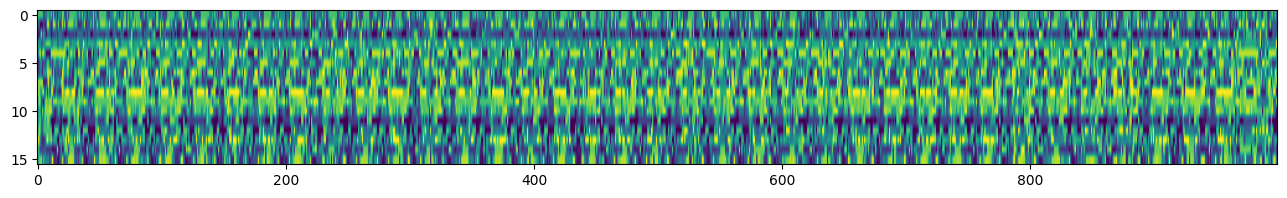

In [49]:
data = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_2-VQ_16_head-SeqV10.npy")
plt.figure(figsize=(16, 2)) 
plt.imshow(data['indices'][0][0:1000].T, aspect='auto', cmap='viridis')

In [33]:
visualize_force_applied(res['body_index'],
                        res['applied_force'],
                        res['change_points'],
                        start_point=0,
                        plot_index=True)

In [34]:
visualize_legged_robot_contacts(
    contacts = res['contact'],
    change_points= res['change_points'],
    start_step=0,
)

In [41]:
list_path = parse_dir("logs/Eval/iid/v05/40N")
list_data_name = ['PPO','PPO1','RMA','RMA1']

In [68]:
list_vel_x, list_vel_z, list_vel_roll,change_points,list_body_force = prepare_sequential_data(list_path,
                                                                              start_step=200,
                                                                              end_step=220,
                                                                              agent_id=0,
                                                                              force_threshold=1)

N force  1
[8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
(20,) [49.99991  0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.     ]
N force  1
[8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
(20,) [ 0.      49.99991 49.99991 49.99991 49.99991 49.99991 49.99991 49.99991
 49.99991 49.99991 49.99991 49.99991 49.99991 49.99991 49.99991 49.99991
 49.99991 49.99991 49.99991 49.99991]
N force  1
[0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
(20,) [ 0.      49.99976 49.99976 49.99976 49.99976 49.99976 49.99976 49.99976
 49.99976 49.99976 49.99976 49.99976 49.99976 49.99976 49.99976 49.99976
 49.99976 49.99976 49.99976 49.99976]
N force  1
[0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
(20,) [ 0.       49.999756 49.999756 49.999756 49.999756 49.999756 49.999756
 49.999756 49.999756 49.999756 49.999756 49.999756 49.999756 49.999756
 49.999756 49.999756 49.999756 49.999756 49.999756 49.999756]


In [62]:
list_body_force[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [55]:
sequential_compare(
    list_vel_x, list_vel_z, list_vel_roll,list_data_name, start_step=200, change_points=change_points,
    title=None, title_fontsize=14, xlabel_fontsize=14, ylabel_fontsize=14,
    save_path=None, subplot_spacing=0.4,xtick_fontsize = 14,
    save_name = 'SequentialCompare'
)

# 特征分析

In [5]:
def get_clustering_data(path):
    data = load_data(path)
    res = {}
    # name = data['name']
    n_agent = len(data['first_done']) 
    # res['eval_name'] = name

    list_indices = []
    list_latents = [] 
    list_fall_rate = []
    # check_data(data)
    for i in range(n_agent):
        first_done = data['first_done'][i]
        
        list_fall_rate.append(data['Fall'][i])


    res['fall_rate'] = list_fall_rate
    return res  

In [14]:
data1 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_0-VQ_16_head-SeqV10.npy")
data2 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_1-VQ_16_head-SeqV10.npy")
data12 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_2-VQ_16_head-SeqV10.npy")

step_size = 800
latent1  = data1['latents'][0,0:step_size]
latent2  = data2['latents'][0,0:step_size]
latent12  = data12['latents'][0,0:step_size]
# plt.figure(figsize=(16, 2)) 
# plt.imshow(data['indices'][0][0:1000].T, aspect='auto', cmap='viridis')

In [15]:
# import pca from sklearn 
from sklearn.decomposition import PCA
def pca(data,n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    return pca.transform(data)

all_latent = np.concatenate([latent1,latent2,latent12],axis=0)
pca_latent = pca(all_latent,n_components=2) 

# split pca_latent
pca_latent1 = pca_latent[0:step_size]
pca_latent2 = pca_latent[step_size:2 * step_size]
pca_latent12 = pca_latent[2 * step_size :3 * step_size]

# visualize pca_latent separately in one figure 
plt.figure(figsize=(16, 2))
plt.plot(np.arange(step_size),pca_latent1[:,0],label = 'Clustering 1-1')
plt.plot(np.arange(step_size),pca_latent1[:,1],label = 'Clustering 1-2')

plt.plot(np.arange(step_size),pca_latent2[:,0],label = 'Clustering 2-1')
plt.plot(np.arange(step_size),pca_latent2[:,1],label = 'Clustering 2-2')

plt.plot(np.arange(step_size),pca_latent12[:,0],label = 'Clustering 3-1')
plt.plot(np.arange(step_size),pca_latent12[:,1],label = 'Clustering 3-2')
plt.legend()

In [16]:
plt.figure(figsize=(10, 10))
plt.scatter(pca_latent1[:,0],pca_latent1[:,1],label = 'Clustering 1')

plt.scatter(pca_latent2[:,0],pca_latent2[:,1],label = 'Clustering 2')

plt.scatter(pca_latent12[:,0],pca_latent12[:,1],label = 'Clustering 3')

plt.legend()

# Tmp

In [30]:
data1 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_0-VQ_16_head-SeqV10.npy")
data2 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_1-VQ_16_head-SeqV10.npy")
data12 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_2-VQ_16_head-SeqV10.npy")

n_agent = 10
step_size = 1000
max_vq_num = 16 
indices1 = data1['indices'][0:n_agent,0:step_size].reshape((n_agent * step_size,-1))
indices2 = data2['indices'][0:n_agent,0:step_size].reshape((n_agent * step_size,-1))
indices12 = data12['indices'][0:n_agent,0:step_size].reshape((n_agent * step_size,-1))
# max_indices = np.max([np.max(indices1),np.max(indices2),np.max(indices12)])
max_indices = 128
# normalize the indices into [0,1] 
indices1 = indices1 / max_indices
indices2 = indices2 / max_indices
indices12 = indices12 / max_indices

print(indices1.shape)
# for each dim in indices1.shape[1], plot the recurrent indices which is indices1[0:-1,0],indices1[1:,0]
# initialize the figure with 4 * 4 subplots 
fig, axs = plt.subplots(4, 4, figsize=(16, 16), sharex=True)
for i in range(max_vq_num):
    # get the recurrent indices 
    recurrent_indices1 = indices1[0:-1,i]
    recurrent_indices2 = indices2[0:-1,i]
    recurrent_indices12 = indices12[0:-1,i]
    # get the next indices 
    next_indices1 = indices1[1:,i]
    next_indices2 = indices2[1:,i]
    next_indices12 = indices12[1:,i]
    # plot the recurrent indices and next indices 
    axs[i // 4, i % 4].scatter(recurrent_indices1,next_indices1,label = 'Clustering 1')
    # axs[i // 4, i % 4].scatter(recurrent_indices2,next_indices2,label = 'Clustering 2')
    # axs[i // 4, i % 4].scatter(recurrent_indices12,next_indices12,label = 'Clustering 3')
    axs[i // 4, i % 4].set_xlabel(f'VQ {i}')
    axs[i // 4, i % 4].set_ylabel(f'VQ {i+1}')
    axs[i // 4, i % 4].legend()


(10000, 16)


(10000, 16)


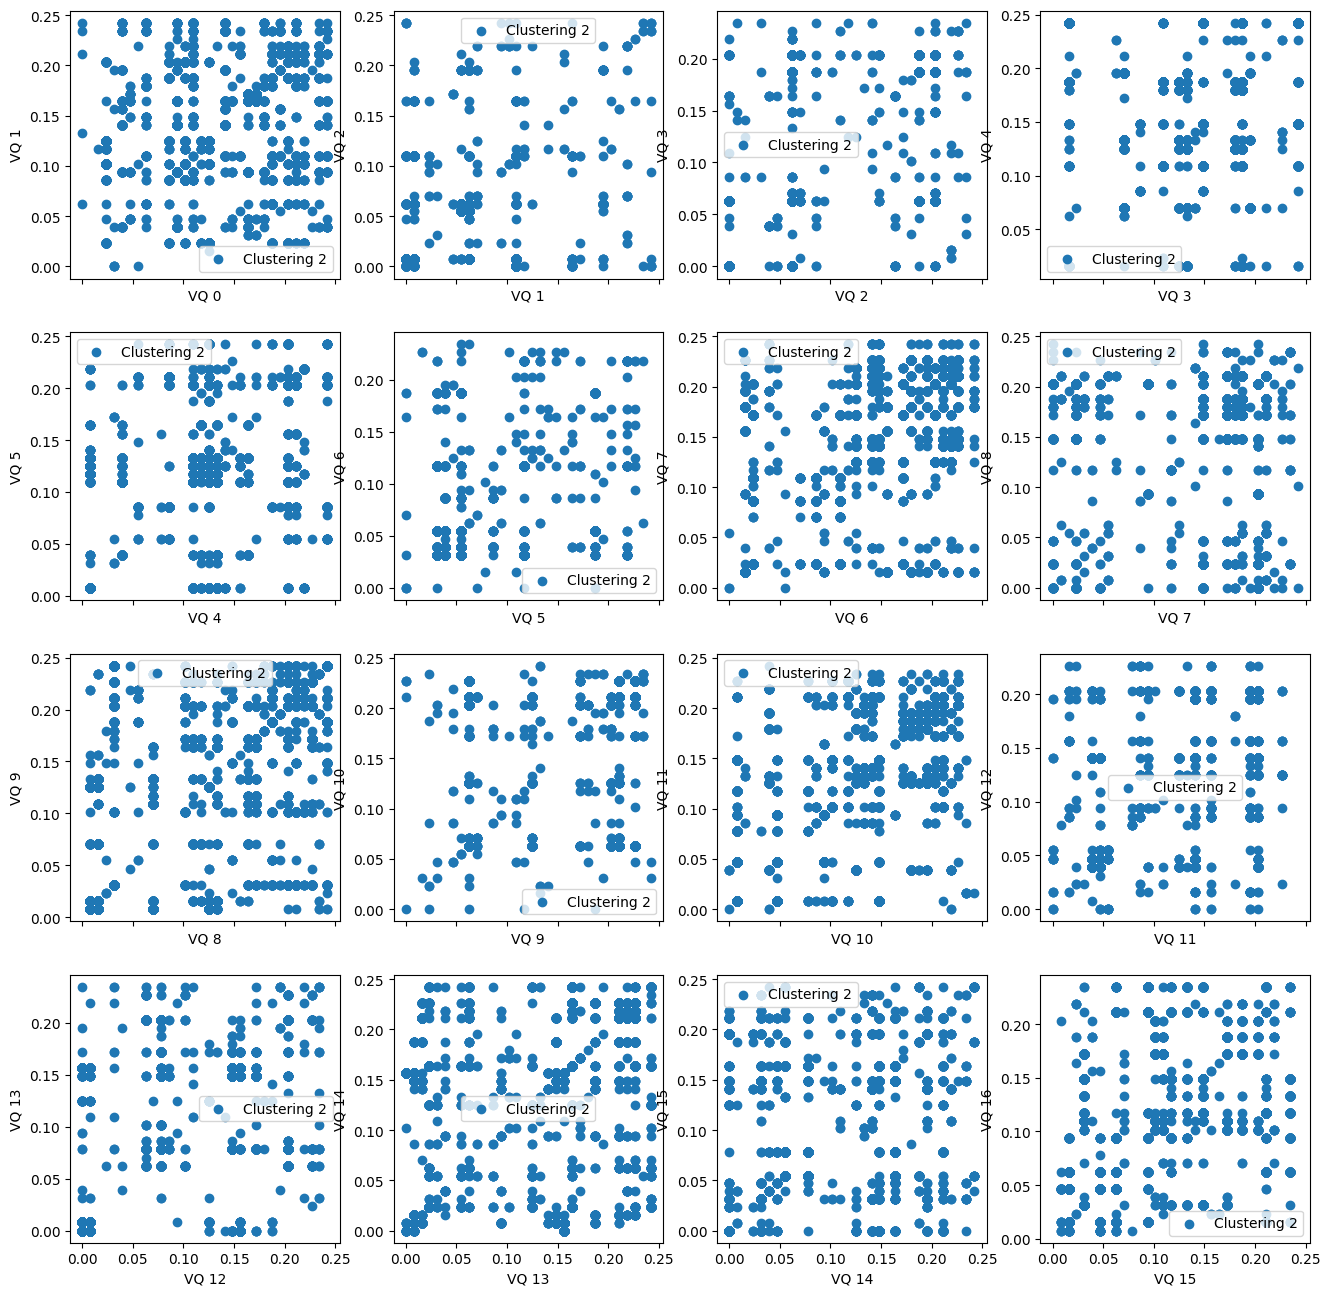

In [31]:
data1 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_0-VQ_16_head-SeqV10.npy")
data2 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_1-VQ_16_head-SeqV10.npy")
data12 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_2-VQ_16_head-SeqV10.npy")

n_agent = 10
step_size = 1000
max_vq_num = 16 
indices1 = data1['indices'][0:n_agent,0:step_size].reshape((n_agent * step_size,-1))
indices2 = data2['indices'][0:n_agent,0:step_size].reshape((n_agent * step_size,-1))
indices12 = data12['indices'][0:n_agent,0:step_size].reshape((n_agent * step_size,-1))
# max_indices = np.max([np.max(indices1),np.max(indices2),np.max(indices12)])
max_indices = 128
indices1 = indices1 / max_indices
indices2 = indices2 / max_indices
indices12 = indices12 / max_indices

print(indices1.shape)
# for each dim in indices1.shape[1], plot the recurrent indices which is indices1[0:-1,0],indices1[1:,0]
# initialize the figure with 4 * 4 subplots 
fig, axs = plt.subplots(4, 4, figsize=(16, 16), sharex=True)
for i in range(max_vq_num):
    # get the recurrent indices 
    recurrent_indices1 = indices1[0:-1,i]
    recurrent_indices2 = indices2[0:-1,i]
    recurrent_indices12 = indices12[0:-1,i]
    # get the next indices 
    next_indices1 = indices1[1:,i]
    next_indices2 = indices2[1:,i]
    next_indices12 = indices12[1:,i]
    # plot the recurrent indices and next indices 
    # axs[i // 4, i % 4].scatter(recurrent_indices1,next_indices1,label = 'Clustering 1')
    axs[i // 4, i % 4].scatter(recurrent_indices2,next_indices2,label = 'Clustering 2')
    # axs[i // 4, i % 4].scatter(recurrent_indices12,next_indices12,label = 'Clustering 3')
    axs[i // 4, i % 4].set_xlabel(f'VQ {i}')
    axs[i // 4, i % 4].set_ylabel(f'VQ {i+1}')
    axs[i // 4, i % 4].legend()


(10000, 16)


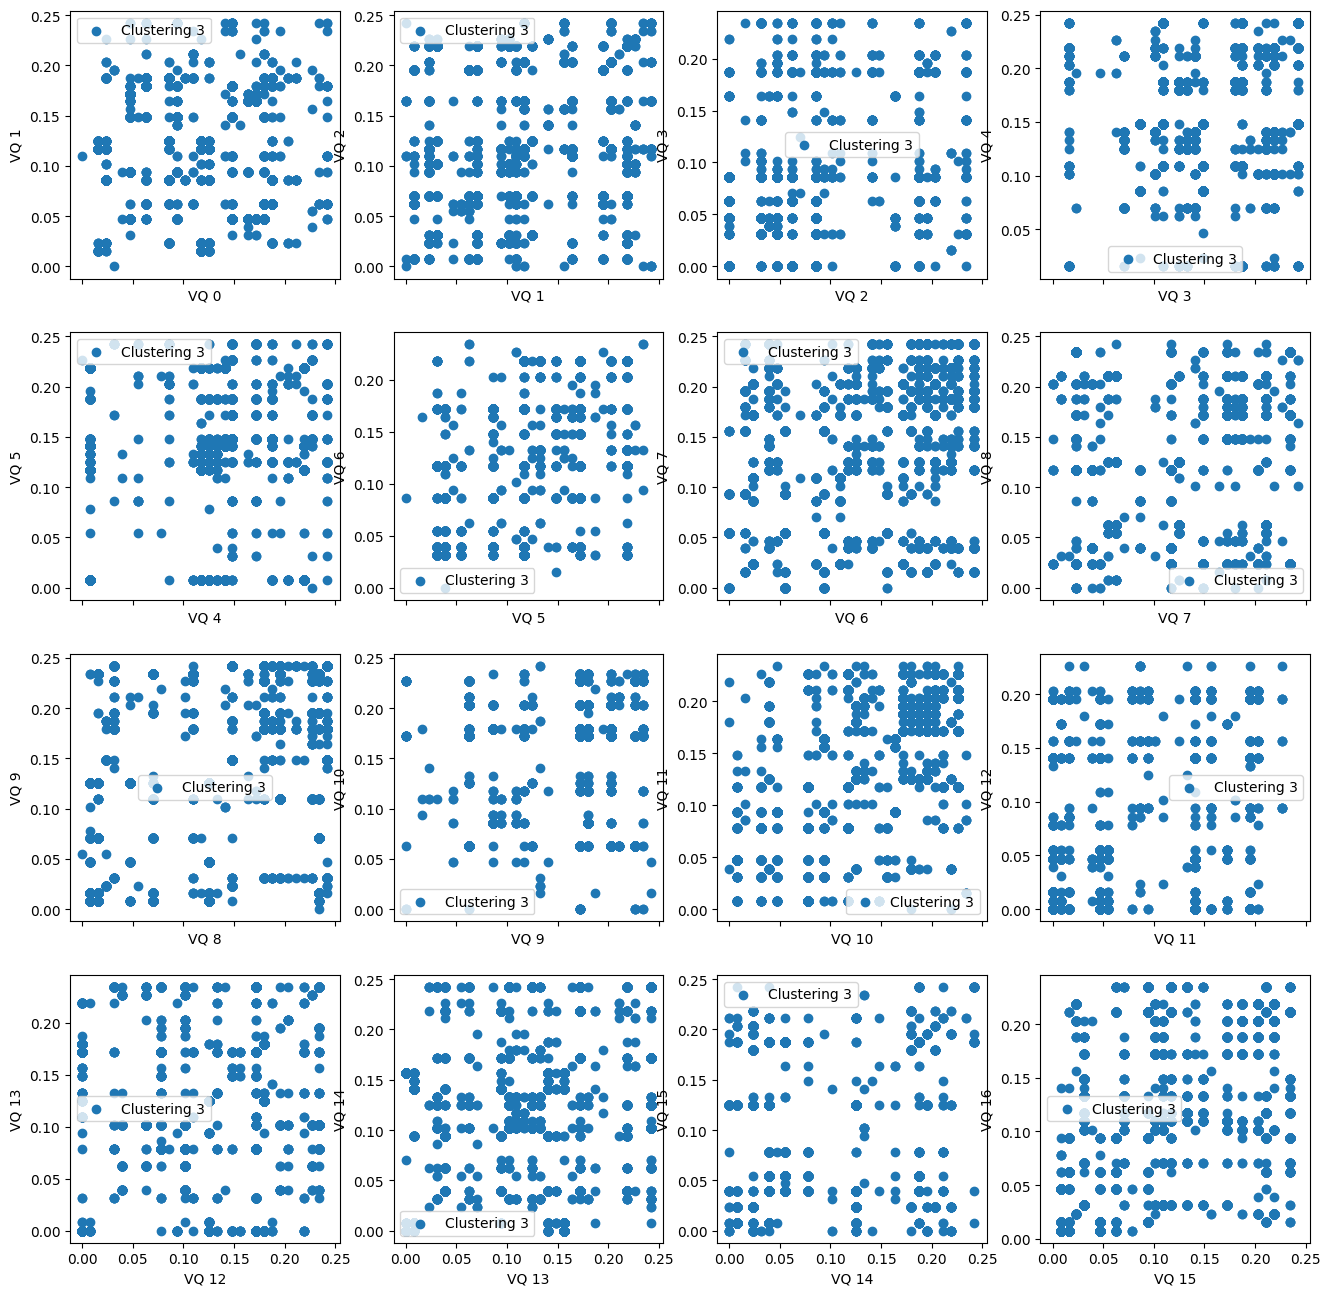

In [32]:
data1 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_0-VQ_16_head-SeqV10.npy")
data2 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_1-VQ_16_head-SeqV10.npy")
data12 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_2-VQ_16_head-SeqV10.npy")

n_agent = 10
step_size = 1000
max_vq_num = 16 
indices1 = data1['indices'][0:n_agent,0:step_size].reshape((n_agent * step_size,-1))
indices2 = data2['indices'][0:n_agent,0:step_size].reshape((n_agent * step_size,-1))
indices12 = data12['indices'][0:n_agent,0:step_size].reshape((n_agent * step_size,-1))
# max_indices = np.max([np.max(indices1),np.max(indices2),np.max(indices12)])
max_indices = 128# normalize the indices into [0,1] 
indices1 = indices1 / max_indices
indices2 = indices2 / max_indices
indices12 = indices12 / max_indices

print(indices1.shape)
# for each dim in indices1.shape[1], plot the recurrent indices which is indices1[0:-1,0],indices1[1:,0]
# initialize the figure with 4 * 4 subplots 
fig, axs = plt.subplots(4, 4, figsize=(16, 16), sharex=True)
for i in range(max_vq_num):
    # get the recurrent indices 
    recurrent_indices1 = indices1[0:-1,i]
    recurrent_indices2 = indices2[0:-1,i]
    recurrent_indices12 = indices12[0:-1,i]
    # get the next indices 
    next_indices1 = indices1[1:,i]
    next_indices2 = indices2[1:,i]
    next_indices12 = indices12[1:,i]
    # plot the recurrent indices and next indices 
    # axs[i // 4, i % 4].scatter(recurrent_indices1,next_indices1,label = 'Clustering 1')
    # axs[i // 4, i % 4].scatter(recurrent_indices2,next_indices2,label = 'Clustering 2')
    axs[i // 4, i % 4].scatter(recurrent_indices12,next_indices12,label = 'Clustering 3')
    axs[i // 4, i % 4].set_xlabel(f'VQ {i}')
    axs[i // 4, i % 4].set_ylabel(f'VQ {i+1}')
    axs[i // 4, i % 4].legend()


(10000, 16)


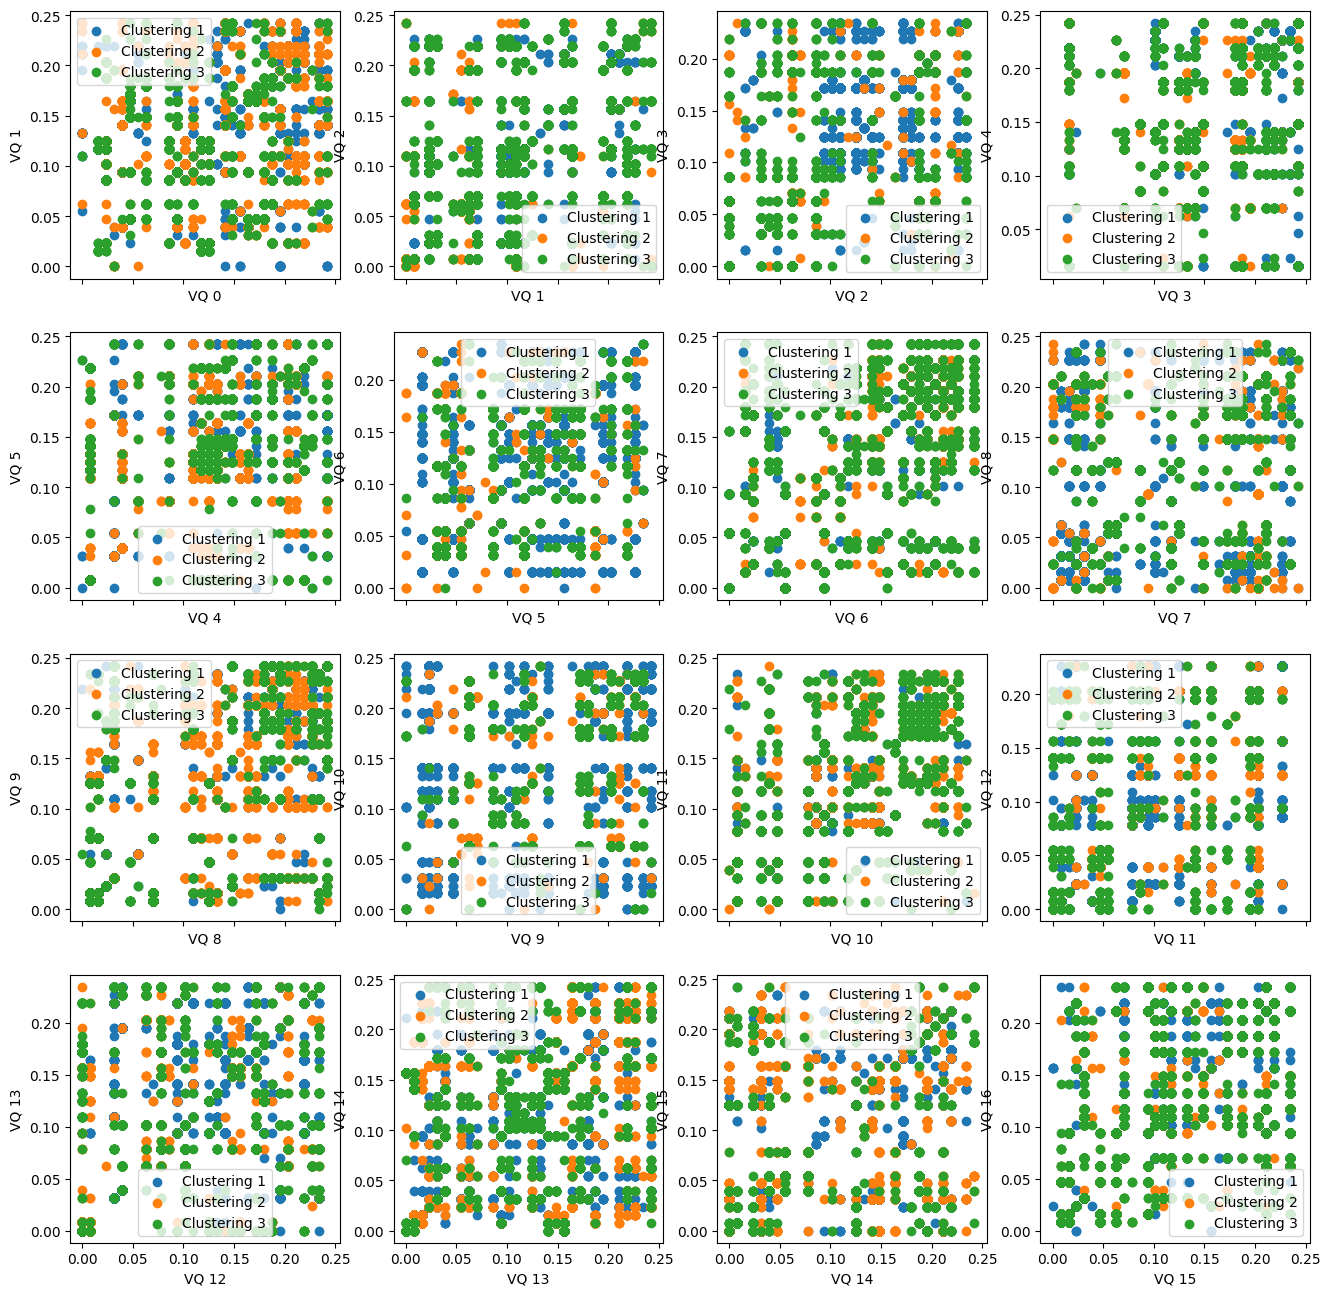

In [33]:
data1 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_0-VQ_16_head-SeqV10.npy")
data2 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_1-VQ_16_head-SeqV10.npy")
data12 = load_data("logs/Eval3/seq/VQ-STG_4_head-Clustering_2-VQ_16_head-SeqV10.npy")

n_agent = 10
step_size = 1000
max_vq_num = 16 
indices1 = data1['indices'][0:n_agent,0:step_size].reshape((n_agent * step_size,-1))
indices2 = data2['indices'][0:n_agent,0:step_size].reshape((n_agent * step_size,-1))
indices12 = data12['indices'][0:n_agent,0:step_size].reshape((n_agent * step_size,-1))
# max_indices = np.max([np.max(indices1),np.max(indices2),np.max(indices12)])
max_indices = 128# normalize the indices into [0,1] 
indices1 = indices1 / max_indices
indices2 = indices2 / max_indices
indices12 = indices12 / max_indices

print(indices1.shape)
# for each dim in indices1.shape[1], plot the recurrent indices which is indices1[0:-1,0],indices1[1:,0]
# initialize the figure with 4 * 4 subplots 
fig, axs = plt.subplots(4, 4, figsize=(16, 16), sharex=True)
for i in range(max_vq_num):
    # get the recurrent indices 
    recurrent_indices1 = indices1[0:-1,i]
    recurrent_indices2 = indices2[0:-1,i]
    recurrent_indices12 = indices12[0:-1,i]
    # get the next indices 
    next_indices1 = indices1[1:,i]
    next_indices2 = indices2[1:,i]
    next_indices12 = indices12[1:,i]
    # plot the recurrent indices and next indices 
    axs[i // 4, i % 4].scatter(recurrent_indices1,next_indices1,label = 'Clustering 1')
    axs[i // 4, i % 4].scatter(recurrent_indices2,next_indices2,label = 'Clustering 2')
    axs[i // 4, i % 4].scatter(recurrent_indices12,next_indices12,label = 'Clustering 3')
    axs[i // 4, i % 4].set_xlabel(f'VQ {i}')
    axs[i // 4, i % 4].set_ylabel(f'VQ {i+1}')
    axs[i // 4, i % 4].legend()
